# NYC Taxi Trip Duration Prediction - LightGBM
***

<a id=path></a>
# Set Local Path
We need to set the local path to read and write to the file.
***

In [1]:
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab - Remove sample data')
  !rm -r sample_data
else:
  print('Not running on CoLab - Continue')

Not running on CoLab - Continue


# Import dataset from Amazon S3 storage
***

In [2]:
!wget https://seminar-ml-2020.s3.amazonaws.com/NYC_DS_After.zip -P ./datasets
!unzip ./datasets/NYC_DS_After.zip -d ./datasets
!rm ./datasets/NYC_DS_After.zip

--2021-01-13 11:50:33--  https://seminar-ml-2020.s3.amazonaws.com/NYC_DS_After.zip
Resolving seminar-ml-2020.s3.amazonaws.com (seminar-ml-2020.s3.amazonaws.com)... 52.216.88.219
Connecting to seminar-ml-2020.s3.amazonaws.com (seminar-ml-2020.s3.amazonaws.com)|52.216.88.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 177761819 (170M) [application/zip]
Saving to: ‘./datasets/NYC_DS_After.zip’

NYC_DS_After.zip    100%[===================>] 169.53M  17.3MB/s    in 10s     

2021-01-13 11:50:44 (16.2 MB/s) - ‘./datasets/NYC_DS_After.zip’ saved [177761819/177761819]

Archive:  ./datasets/NYC_DS_After.zip
  inflating: ./datasets/train_ds.csv  
  inflating: ./datasets/test_ds.csv  


<a id=library></a>
# Import libraries
***

In [3]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
from time import perf_counter

# Import to Show image in Jupyter Notebook
from IPython.display import Image
%matplotlib inline

<a id=data></a>
# Import Dataset
***

In [4]:
!ls

anaconda3  datasets  prediction_with_lgbm.ipynb


In [80]:
train_df=pd.read_csv("./datasets/train_ds.csv")
test_df=pd.read_csv("./datasets/test_ds.csv")

In [81]:
y = np.log(train_df['trip_duration'].values)

In [82]:
DO_NOT_USE_FOR_TRAINING = ['id', 'pickup_datetime', 'dropoff_datetime','pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'trip_duration', 'date',
       'month', 'weekday', 'hour', 'minute', 'second', 'passenger_count',
       'distance', 'best_travel_time', 'left',
       'right', 'merge', 'on ramp', 'off ramp', 'fork', 'end of road',
       'continue', 'roundabout', 'rotary', 'roundabout turn', 
       'average temperature','departure', 'HDD', 'CDD', 'snow fall']

In [83]:
train_df = train_df.drop([col for col in DO_NOT_USE_FOR_TRAINING if col in train_df], axis=1)
new_test = test_df.drop([col for col in DO_NOT_USE_FOR_TRAINING if col in test_df], axis=1)

<a id=splitdata></a>
## Split data to train and validation
***
For comparing the results for raw and optimized data, we'll split and use both

In [84]:
train_x, val_x, train_y, val_y = train_test_split(train_df, y, test_size=0.2)

<a id=lgbm></a>
# LightGBM Regressor
***
LightGBM is a gradiant boosting framework originally developed by Microsoft.
Unlike most decision tree algorithms which grow trees by level (depth)-wise, lighGBM grows trees leaf-wise (best-first) and tend to achieve lower loss than level-wise algorithms.
Leaf wise splits lead to increase in complexity and may lead to overfitting and it can be overcome by specifying another parameter max-depth which specifies the depth to which splitting will occur.

Advantages of LightGBM:
-Faster training speed and higher efficiency: Light GBM use histogram based algorithm i.e it buckets continuous feature values into discrete bins which fasten the training procedure.
-Lower memory usage: Replaces continuous values to discrete bins which result in lower memory usage.
-Better accuracy than any other boosting algorithm: It produces much more complex trees by following leaf wise split approach rather than a level-wise approach which is the main factor in achieving higher accuracy. However, it can sometimes lead to overfitting which can be avoided by setting the max_depth parameter.
-Compatibility with Large Datasets: It is capable of performing equally good with large datasets with a significant reduction in training time as compared to XGBOOST.
-Parallel learning supported.

In [85]:
# self-defined eval metric
# Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y_true, y_pred):
    return 'RMSLE', np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2))), False

In [17]:
params = {
    "n_estimators" : [100, 200, 500, 1000],
    "max_depth" : [6, 10, 14, 20, -1],
    "bagging_fraction" : [0.4, 0.6, 1],
    "bagging_freq" : [2,4,6,8],
    "reg_alpha" : [0.0,0.6,0.8,1.0],
    "reg_lambda" : [0.0,0.6,0.8,1.0],
    "learning_rate" : [0.1, 0.01, 0.001]
}

In [18]:
gbm = lgb.LGBMRegressor()
best_gbm = RandomizedSearchCV(gbm,params,verbose=1,cv=5, scoring='neg_mean_squared_log_error', n_jobs = -1, n_iter=10)  # cv for params

In [19]:
for iter in tqdm(np.arange(50)):
        best_gbm.fit(train_x, train_y, eval_set = [(val_x, val_y)], eval_metric = rmsle, early_stopping_rounds = 4)

  0%|          | 0/50 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.3min finished


[1]	valid_0's l2: 0.459428	valid_0's RMSLE: 0.0927714
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.404904	valid_0's RMSLE: 0.0872923
[3]	valid_0's l2: 0.360205	valid_0's RMSLE: 0.0825244
[4]	valid_0's l2: 0.32356	valid_0's RMSLE: 0.0783811
[5]	valid_0's l2: 0.293587	valid_0's RMSLE: 0.0748167
[6]	valid_0's l2: 0.269106	valid_0's RMSLE: 0.0717649
[7]	valid_0's l2: 0.248547	valid_0's RMSLE: 0.0690874
[8]	valid_0's l2: 0.23183	valid_0's RMSLE: 0.0668187
[9]	valid_0's l2: 0.217964	valid_0's RMSLE: 0.064876
[10]	valid_0's l2: 0.206446	valid_0's RMSLE: 0.0632052
[11]	valid_0's l2: 0.196886	valid_0's RMSLE: 0.0617762
[12]	valid_0's l2: 0.18898	valid_0's RMSLE: 0.060561
[13]	valid_0's l2: 0.182472	valid_0's RMSLE: 0.0595446
[14]	valid_0's l2: 0.176783	valid_0's RMSLE: 0.0586425
[15]	valid_0's l2: 0.172105	valid_0's RMSLE: 0.0578817
[16]	valid_0's l2: 0.168269	valid_0's RMSLE: 0.0572508
[17]	valid_0's l2: 0.165001	valid_0's RMSLE: 0.0567073
[18]	valid_0's l2: 

  2%|▏         | 1/50 [03:31<2:52:20, 211.03s/it]

[499]	valid_0's l2: 0.118959	valid_0's RMSLE: 0.0484281
[500]	valid_0's l2: 0.118948	valid_0's RMSLE: 0.0484259
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.118948	valid_0's RMSLE: 0.0484259
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.4min finished


[1]	valid_0's l2: 0.459427	valid_0's RMSLE: 0.0927713
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.404903	valid_0's RMSLE: 0.0872922
[3]	valid_0's l2: 0.360204	valid_0's RMSLE: 0.0825242
[4]	valid_0's l2: 0.323558	valid_0's RMSLE: 0.0783809
[5]	valid_0's l2: 0.293584	valid_0's RMSLE: 0.0748163
[6]	valid_0's l2: 0.269103	valid_0's RMSLE: 0.0717645
[7]	valid_0's l2: 0.248544	valid_0's RMSLE: 0.0690869
[8]	valid_0's l2: 0.231827	valid_0's RMSLE: 0.0668182
[9]	valid_0's l2: 0.21796	valid_0's RMSLE: 0.0648755
[10]	valid_0's l2: 0.206443	valid_0's RMSLE: 0.0632047
[11]	valid_0's l2: 0.196882	valid_0's RMSLE: 0.0617757
[12]	valid_0's l2: 0.188977	valid_0's RMSLE: 0.0605605
[13]	valid_0's l2: 0.182468	valid_0's RMSLE: 0.0595441
[14]	valid_0's l2: 0.17678	valid_0's RMSLE: 0.058642
[15]	valid_0's l2: 0.172101	valid_0's RMSLE: 0.0578812
[16]	valid_0's l2: 0.168266	valid_0's RMSLE: 0.0572503
[17]	valid_0's l2: 0.164998	valid_0's RMSLE: 0.0567068
[18]	valid_0's l2

  4%|▍         | 2/50 [06:21<2:39:07, 198.90s/it]

[976]	valid_0's l2: 0.115447	valid_0's RMSLE: 0.047732
[977]	valid_0's l2: 0.115447	valid_0's RMSLE: 0.0477323
[978]	valid_0's l2: 0.115445	valid_0's RMSLE: 0.047732
[979]	valid_0's l2: 0.115447	valid_0's RMSLE: 0.0477324
[980]	valid_0's l2: 0.115448	valid_0's RMSLE: 0.0477327
[981]	valid_0's l2: 0.115447	valid_0's RMSLE: 0.0477325
[982]	valid_0's l2: 0.115444	valid_0's RMSLE: 0.0477322
Early stopping, best iteration is:
[978]	valid_0's l2: 0.115445	valid_0's RMSLE: 0.047732
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.5min finished


[1]	valid_0's l2: 0.459464	valid_0's RMSLE: 0.0927739
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.404765	valid_0's RMSLE: 0.087277
[3]	valid_0's l2: 0.360049	valid_0's RMSLE: 0.0825077
[4]	valid_0's l2: 0.323605	valid_0's RMSLE: 0.0783901
[5]	valid_0's l2: 0.293625	valid_0's RMSLE: 0.0748244
[6]	valid_0's l2: 0.269016	valid_0's RMSLE: 0.0717556
[7]	valid_0's l2: 0.248751	valid_0's RMSLE: 0.0691133
[8]	valid_0's l2: 0.231933	valid_0's RMSLE: 0.0668396
[9]	valid_0's l2: 0.218344	valid_0's RMSLE: 0.0649294
[10]	valid_0's l2: 0.206748	valid_0's RMSLE: 0.0632423
[11]	valid_0's l2: 0.196978	valid_0's RMSLE: 0.0617944
[12]	valid_0's l2: 0.188894	valid_0's RMSLE: 0.0605618
[13]	valid_0's l2: 0.182417	valid_0's RMSLE: 0.0595447
[14]	valid_0's l2: 0.176822	valid_0's RMSLE: 0.0586525
[15]	valid_0's l2: 0.172118	valid_0's RMSLE: 0.0578841
[16]	valid_0's l2: 0.168262	valid_0's RMSLE: 0.057244
[17]	valid_0's l2: 0.16492	valid_0's RMSLE: 0.0566863
[18]	valid_0's l2

  6%|▌         | 3/50 [09:59<2:40:13, 204.55s/it]

Early stopping, best iteration is:
[258]	valid_0's l2: 0.124678	valid_0's RMSLE: 0.0495411
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.1min finished


[1]	valid_0's l2: 0.459457	valid_0's RMSLE: 0.0927724
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.404948	valid_0's RMSLE: 0.0872955
[3]	valid_0's l2: 0.360276	valid_0's RMSLE: 0.0825268
[4]	valid_0's l2: 0.323871	valid_0's RMSLE: 0.0784102
[5]	valid_0's l2: 0.293884	valid_0's RMSLE: 0.0748458
[6]	valid_0's l2: 0.269419	valid_0's RMSLE: 0.0717965
[7]	valid_0's l2: 0.249158	valid_0's RMSLE: 0.0691626
[8]	valid_0's l2: 0.232696	valid_0's RMSLE: 0.0669404
[9]	valid_0's l2: 0.218671	valid_0's RMSLE: 0.0649717
[10]	valid_0's l2: 0.207033	valid_0's RMSLE: 0.0632901
[11]	valid_0's l2: 0.197678	valid_0's RMSLE: 0.0619022
[12]	valid_0's l2: 0.189788	valid_0's RMSLE: 0.0607005
[13]	valid_0's l2: 0.183115	valid_0's RMSLE: 0.0596578
[14]	valid_0's l2: 0.177578	valid_0's RMSLE: 0.058772
[15]	valid_0's l2: 0.173078	valid_0's RMSLE: 0.0580391
[16]	valid_0's l2: 0.168952	valid_0's RMSLE: 0.0573611
[17]	valid_0's l2: 0.165618	valid_0's RMSLE: 0.0568071
[18]	valid_0's 

  8%|▊         | 4/50 [14:10<2:47:38, 218.67s/it]

[196]	valid_0's l2: 0.127032	valid_0's RMSLE: 0.0499967
[197]	valid_0's l2: 0.126958	valid_0's RMSLE: 0.0499827
[198]	valid_0's l2: 0.126924	valid_0's RMSLE: 0.0499771
[199]	valid_0's l2: 0.126888	valid_0's RMSLE: 0.0499711
[200]	valid_0's l2: 0.126867	valid_0's RMSLE: 0.0499669
Did not meet early stopping. Best iteration is:
[200]	valid_0's l2: 0.126867	valid_0's RMSLE: 0.0499669
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.2min finished


[1]	valid_0's l2: 0.459465	valid_0's RMSLE: 0.092774
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.404766	valid_0's RMSLE: 0.0872771
[3]	valid_0's l2: 0.36005	valid_0's RMSLE: 0.0825077
[4]	valid_0's l2: 0.323606	valid_0's RMSLE: 0.0783901
[5]	valid_0's l2: 0.293625	valid_0's RMSLE: 0.0748245
[6]	valid_0's l2: 0.269016	valid_0's RMSLE: 0.0717557
[7]	valid_0's l2: 0.248751	valid_0's RMSLE: 0.0691133
[8]	valid_0's l2: 0.231933	valid_0's RMSLE: 0.0668396
[9]	valid_0's l2: 0.218344	valid_0's RMSLE: 0.0649294
[10]	valid_0's l2: 0.206748	valid_0's RMSLE: 0.0632422
[11]	valid_0's l2: 0.196977	valid_0's RMSLE: 0.0617943
[12]	valid_0's l2: 0.188894	valid_0's RMSLE: 0.0605618
[13]	valid_0's l2: 0.182416	valid_0's RMSLE: 0.0595446
[14]	valid_0's l2: 0.176822	valid_0's RMSLE: 0.0586524
[15]	valid_0's l2: 0.172117	valid_0's RMSLE: 0.057884
[16]	valid_0's l2: 0.168261	valid_0's RMSLE: 0.0572439
[17]	valid_0's l2: 0.16492	valid_0's RMSLE: 0.0566861
[18]	valid_0's l2:

 10%|█         | 5/50 [17:27<2:38:54, 211.89s/it]

[198]	valid_0's l2: 0.126344	valid_0's RMSLE: 0.0498559
[199]	valid_0's l2: 0.126333	valid_0's RMSLE: 0.0498538
[200]	valid_0's l2: 0.126315	valid_0's RMSLE: 0.0498506
Did not meet early stopping. Best iteration is:
[200]	valid_0's l2: 0.126315	valid_0's RMSLE: 0.0498506
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.2min finished


[1]	valid_0's l2: 0.459426	valid_0's RMSLE: 0.0927712
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.404901	valid_0's RMSLE: 0.087292
[3]	valid_0's l2: 0.360202	valid_0's RMSLE: 0.082524
[4]	valid_0's l2: 0.323556	valid_0's RMSLE: 0.0783807
[5]	valid_0's l2: 0.293582	valid_0's RMSLE: 0.0748161
[6]	valid_0's l2: 0.269101	valid_0's RMSLE: 0.0717642
[7]	valid_0's l2: 0.248542	valid_0's RMSLE: 0.0690867
[8]	valid_0's l2: 0.231825	valid_0's RMSLE: 0.066818
[9]	valid_0's l2: 0.217958	valid_0's RMSLE: 0.0648753
[10]	valid_0's l2: 0.206441	valid_0's RMSLE: 0.0632045
[11]	valid_0's l2: 0.196881	valid_0's RMSLE: 0.0617755
[12]	valid_0's l2: 0.188976	valid_0's RMSLE: 0.0605604
[13]	valid_0's l2: 0.182467	valid_0's RMSLE: 0.0595439
[14]	valid_0's l2: 0.176779	valid_0's RMSLE: 0.0586418
[15]	valid_0's l2: 0.172101	valid_0's RMSLE: 0.0578811
[16]	valid_0's l2: 0.168266	valid_0's RMSLE: 0.0572502
[17]	valid_0's l2: 0.164998	valid_0's RMSLE: 0.0567068
[18]	valid_0's l2

 12%|█▏        | 6/50 [20:54<2:34:18, 210.42s/it]

[500]	valid_0's l2: 0.118924	valid_0's RMSLE: 0.0484216
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.118924	valid_0's RMSLE: 0.0484216
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.4min finished


[1]	valid_0's l2: 0.459456	valid_0's RMSLE: 0.0927723
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.404947	valid_0's RMSLE: 0.0872954
[3]	valid_0's l2: 0.360274	valid_0's RMSLE: 0.0825266
[4]	valid_0's l2: 0.323869	valid_0's RMSLE: 0.07841
[5]	valid_0's l2: 0.293882	valid_0's RMSLE: 0.0748456
[6]	valid_0's l2: 0.269418	valid_0's RMSLE: 0.0717962
[7]	valid_0's l2: 0.249156	valid_0's RMSLE: 0.0691624
[8]	valid_0's l2: 0.232694	valid_0's RMSLE: 0.0669401
[9]	valid_0's l2: 0.21867	valid_0's RMSLE: 0.0649715
[10]	valid_0's l2: 0.207032	valid_0's RMSLE: 0.0632899
[11]	valid_0's l2: 0.197677	valid_0's RMSLE: 0.061902
[12]	valid_0's l2: 0.189787	valid_0's RMSLE: 0.0607003
[13]	valid_0's l2: 0.183114	valid_0's RMSLE: 0.0596577
[14]	valid_0's l2: 0.177577	valid_0's RMSLE: 0.0587719
[15]	valid_0's l2: 0.173078	valid_0's RMSLE: 0.058039
[16]	valid_0's l2: 0.168951	valid_0's RMSLE: 0.0573609
[17]	valid_0's l2: 0.165617	valid_0's RMSLE: 0.056807
[18]	valid_0's l2: 0

 14%|█▍        | 7/50 [23:42<2:21:45, 197.80s/it]

[997]	valid_0's l2: 0.116006	valid_0's RMSLE: 0.0478256
[998]	valid_0's l2: 0.115997	valid_0's RMSLE: 0.0478236
[999]	valid_0's l2: 0.115996	valid_0's RMSLE: 0.0478234
[1000]	valid_0's l2: 0.115992	valid_0's RMSLE: 0.0478225
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.115992	valid_0's RMSLE: 0.0478225
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.7min finished


[1]	valid_0's l2: 0.459378	valid_0's RMSLE: 0.0927655
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.404771	valid_0's RMSLE: 0.0872804
[3]	valid_0's l2: 0.360046	valid_0's RMSLE: 0.0825093
[4]	valid_0's l2: 0.323601	valid_0's RMSLE: 0.0783885
[5]	valid_0's l2: 0.293611	valid_0's RMSLE: 0.0748229
[6]	valid_0's l2: 0.269127	valid_0's RMSLE: 0.0717706
[7]	valid_0's l2: 0.248732	valid_0's RMSLE: 0.0691153
[8]	valid_0's l2: 0.232129	valid_0's RMSLE: 0.0668626
[9]	valid_0's l2: 0.218187	valid_0's RMSLE: 0.0649022
[10]	valid_0's l2: 0.206426	valid_0's RMSLE: 0.0632043
[11]	valid_0's l2: 0.197044	valid_0's RMSLE: 0.0618129
[12]	valid_0's l2: 0.189035	valid_0's RMSLE: 0.0605857
[13]	valid_0's l2: 0.182429	valid_0's RMSLE: 0.0595468
[14]	valid_0's l2: 0.176921	valid_0's RMSLE: 0.0586623
[15]	valid_0's l2: 0.172355	valid_0's RMSLE: 0.057925
[16]	valid_0's l2: 0.16845	valid_0's RMSLE: 0.0572845
[17]	valid_0's l2: 0.165094	valid_0's RMSLE: 0.0567221
[18]	valid_0's l

 16%|█▌        | 8/50 [26:31<2:12:29, 189.27s/it]

[195]	valid_0's l2: 0.126256	valid_0's RMSLE: 0.0498406
[196]	valid_0's l2: 0.126144	valid_0's RMSLE: 0.0498191
[197]	valid_0's l2: 0.126075	valid_0's RMSLE: 0.0498052
[198]	valid_0's l2: 0.126054	valid_0's RMSLE: 0.0498017
[199]	valid_0's l2: 0.126006	valid_0's RMSLE: 0.0497919
[200]	valid_0's l2: 0.125964	valid_0's RMSLE: 0.0497838
Did not meet early stopping. Best iteration is:
[200]	valid_0's l2: 0.125964	valid_0's RMSLE: 0.0497838
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.0min finished


[1]	valid_0's l2: 0.519517	valid_0's RMSLE: 0.098445
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.51262	valid_0's RMSLE: 0.0978106
[3]	valid_0's l2: 0.505864	valid_0's RMSLE: 0.0971847
[4]	valid_0's l2: 0.499238	valid_0's RMSLE: 0.0965671
[5]	valid_0's l2: 0.492743	valid_0's RMSLE: 0.095958
[6]	valid_0's l2: 0.486377	valid_0's RMSLE: 0.0953571
[7]	valid_0's l2: 0.480133	valid_0's RMSLE: 0.0947639
[8]	valid_0's l2: 0.474009	valid_0's RMSLE: 0.0941785
[9]	valid_0's l2: 0.468001	valid_0's RMSLE: 0.0936003
[10]	valid_0's l2: 0.462119	valid_0's RMSLE: 0.0930307
[11]	valid_0's l2: 0.456354	valid_0's RMSLE: 0.092469
[12]	valid_0's l2: 0.450695	valid_0's RMSLE: 0.0919143
[13]	valid_0's l2: 0.445148	valid_0's RMSLE: 0.0913675
[14]	valid_0's l2: 0.43972	valid_0's RMSLE: 0.090829
[15]	valid_0's l2: 0.434379	valid_0's RMSLE: 0.0902959
[16]	valid_0's l2: 0.429136	valid_0's RMSLE: 0.0897694
[17]	valid_0's l2: 0.424	valid_0's RMSLE: 0.0892505
[18]	valid_0's l2: 0.41

 18%|█▊        | 9/50 [31:04<2:26:28, 214.35s/it]

[996]	valid_0's l2: 0.130989	valid_0's RMSLE: 0.0507281
[997]	valid_0's l2: 0.130986	valid_0's RMSLE: 0.0507276
[998]	valid_0's l2: 0.130984	valid_0's RMSLE: 0.0507272
[999]	valid_0's l2: 0.130982	valid_0's RMSLE: 0.0507268
[1000]	valid_0's l2: 0.130981	valid_0's RMSLE: 0.0507265
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.130981	valid_0's RMSLE: 0.0507265
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.5min finished


[1]	valid_0's l2: 0.459456	valid_0's RMSLE: 0.0927723
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.404947	valid_0's RMSLE: 0.0872954
[3]	valid_0's l2: 0.360274	valid_0's RMSLE: 0.0825266
[4]	valid_0's l2: 0.323869	valid_0's RMSLE: 0.07841
[5]	valid_0's l2: 0.293882	valid_0's RMSLE: 0.0748455
[6]	valid_0's l2: 0.269417	valid_0's RMSLE: 0.0717962
[7]	valid_0's l2: 0.249155	valid_0's RMSLE: 0.0691623
[8]	valid_0's l2: 0.232694	valid_0's RMSLE: 0.06694
[9]	valid_0's l2: 0.218669	valid_0's RMSLE: 0.0649714
[10]	valid_0's l2: 0.207031	valid_0's RMSLE: 0.0632898
[11]	valid_0's l2: 0.197676	valid_0's RMSLE: 0.0619019
[12]	valid_0's l2: 0.189786	valid_0's RMSLE: 0.0607002
[13]	valid_0's l2: 0.183113	valid_0's RMSLE: 0.0596576
[14]	valid_0's l2: 0.177576	valid_0's RMSLE: 0.0587717
[15]	valid_0's l2: 0.173077	valid_0's RMSLE: 0.0580388
[16]	valid_0's l2: 0.16895	valid_0's RMSLE: 0.0573608
[17]	valid_0's l2: 0.165616	valid_0's RMSLE: 0.0568069
[18]	valid_0's l2: 

 20%|██        | 10/50 [34:47<2:24:31, 216.78s/it]

[497]	valid_0's l2: 0.120176	valid_0's RMSLE: 0.0486514
[498]	valid_0's l2: 0.120157	valid_0's RMSLE: 0.0486478
[499]	valid_0's l2: 0.120145	valid_0's RMSLE: 0.0486459
[500]	valid_0's l2: 0.120129	valid_0's RMSLE: 0.0486428
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.120129	valid_0's RMSLE: 0.0486428
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.6min finished


[1]	valid_0's l2: 0.459425	valid_0's RMSLE: 0.0927711
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.404899	valid_0's RMSLE: 0.0872918
[3]	valid_0's l2: 0.360199	valid_0's RMSLE: 0.0825237
[4]	valid_0's l2: 0.323552	valid_0's RMSLE: 0.0783802
[5]	valid_0's l2: 0.293578	valid_0's RMSLE: 0.0748156
[6]	valid_0's l2: 0.269096	valid_0's RMSLE: 0.0717636
[7]	valid_0's l2: 0.248537	valid_0's RMSLE: 0.069086
[8]	valid_0's l2: 0.23182	valid_0's RMSLE: 0.0668173
[9]	valid_0's l2: 0.217953	valid_0's RMSLE: 0.0648745
[10]	valid_0's l2: 0.206436	valid_0's RMSLE: 0.0632037
[11]	valid_0's l2: 0.196876	valid_0's RMSLE: 0.0617748
[12]	valid_0's l2: 0.188971	valid_0's RMSLE: 0.0605596
[13]	valid_0's l2: 0.182463	valid_0's RMSLE: 0.0595432
[14]	valid_0's l2: 0.176774	valid_0's RMSLE: 0.0586411
[15]	valid_0's l2: 0.172096	valid_0's RMSLE: 0.0578803
[16]	valid_0's l2: 0.168261	valid_0's RMSLE: 0.0572495
[17]	valid_0's l2: 0.164993	valid_0's RMSLE: 0.056706
[18]	valid_0's l2

 22%|██▏       | 11/50 [38:47<2:25:26, 223.77s/it]

[987]	valid_0's l2: 0.115589	valid_0's RMSLE: 0.0477662
Early stopping, best iteration is:
[983]	valid_0's l2: 0.115586	valid_0's RMSLE: 0.0477651
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.2min finished


[1]	valid_0's l2: 0.459425	valid_0's RMSLE: 0.0927711
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.4049	valid_0's RMSLE: 0.0872919
[3]	valid_0's l2: 0.3602	valid_0's RMSLE: 0.0825238
[4]	valid_0's l2: 0.323554	valid_0's RMSLE: 0.0783804
[5]	valid_0's l2: 0.29358	valid_0's RMSLE: 0.0748158
[6]	valid_0's l2: 0.269098	valid_0's RMSLE: 0.0717638
[7]	valid_0's l2: 0.248539	valid_0's RMSLE: 0.0690863
[8]	valid_0's l2: 0.231822	valid_0's RMSLE: 0.0668176
[9]	valid_0's l2: 0.217956	valid_0's RMSLE: 0.0648748
[10]	valid_0's l2: 0.206438	valid_0's RMSLE: 0.0632041
[11]	valid_0's l2: 0.196878	valid_0's RMSLE: 0.0617751
[12]	valid_0's l2: 0.188973	valid_0's RMSLE: 0.0605599
[13]	valid_0's l2: 0.182465	valid_0's RMSLE: 0.0595435
[14]	valid_0's l2: 0.176777	valid_0's RMSLE: 0.0586414
[15]	valid_0's l2: 0.172099	valid_0's RMSLE: 0.0578807
[16]	valid_0's l2: 0.168264	valid_0's RMSLE: 0.0572498
[17]	valid_0's l2: 0.164995	valid_0's RMSLE: 0.0567064
[18]	valid_0's l2: 

 24%|██▍       | 12/50 [42:22<2:20:12, 221.38s/it]

[908]	valid_0's l2: 0.115816	valid_0's RMSLE: 0.0478019
[909]	valid_0's l2: 0.115813	valid_0's RMSLE: 0.0478014
[910]	valid_0's l2: 0.11581	valid_0's RMSLE: 0.0478007
[911]	valid_0's l2: 0.115809	valid_0's RMSLE: 0.0478005
[912]	valid_0's l2: 0.115811	valid_0's RMSLE: 0.0478012
[913]	valid_0's l2: 0.11581	valid_0's RMSLE: 0.047801
[914]	valid_0's l2: 0.115809	valid_0's RMSLE: 0.0478007
[915]	valid_0's l2: 0.115809	valid_0's RMSLE: 0.0478009
Early stopping, best iteration is:
[911]	valid_0's l2: 0.115809	valid_0's RMSLE: 0.0478005
Fitting 5 folds for each of 10 candidates, totalling 50 fits

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.0min finished


[1]	valid_0's l2: 0.459462	valid_0's RMSLE: 0.0927736
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.404761	valid_0's RMSLE: 0.0872766
[3]	valid_0's l2: 0.35999	valid_0's RMSLE: 0.0825013
[4]	valid_0's l2: 0.323597	valid_0's RMSLE: 0.0783872
[5]	valid_0's l2: 0.293549	valid_0's RMSLE: 0.0748067
[6]	valid_0's l2: 0.269228	valid_0's RMSLE: 0.0717732
[7]	valid_0's l2: 0.248913	valid_0's RMSLE: 0.0691311
[8]	valid_0's l2: 0.232081	valid_0's RMSLE: 0.0668556
[9]	valid_0's l2: 0.218242	valid_0's RMSLE: 0.0649089
[10]	valid_0's l2: 0.206606	valid_0's RMSLE: 0.063226
[11]	valid_0's l2: 0.197137	valid_0's RMSLE: 0.0618166
[12]	valid_0's l2: 0.189045	valid_0's RMSLE: 0.0605807
[13]	valid_0's l2: 0.182337	valid_0's RMSLE: 0.0595269
[14]	valid_0's l2: 0.176917	valid_0's RMSLE: 0.0586655
[15]	valid_0's l2: 0.172176	valid_0's RMSLE: 0.0579012
[16]	valid_0's l2: 0.168299	valid_0's RMSLE: 0.0572523
[17]	valid_0's l2: 0.165061	valid_0's RMSLE: 0.0567116
[18]	valid_0's l

 26%|██▌       | 13/50 [45:31<2:10:27, 211.55s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.7min finished


[1]	valid_0's l2: 0.459377	valid_0's RMSLE: 0.0927653
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.404768	valid_0's RMSLE: 0.0872801
[3]	valid_0's l2: 0.360043	valid_0's RMSLE: 0.082509
[4]	valid_0's l2: 0.323597	valid_0's RMSLE: 0.0783882
[5]	valid_0's l2: 0.293461	valid_0's RMSLE: 0.0748053
[6]	valid_0's l2: 0.269067	valid_0's RMSLE: 0.0717652
[7]	valid_0's l2: 0.248487	valid_0's RMSLE: 0.0690832
[8]	valid_0's l2: 0.231565	valid_0's RMSLE: 0.0667875
[9]	valid_0's l2: 0.217955	valid_0's RMSLE: 0.0648767
[10]	valid_0's l2: 0.206449	valid_0's RMSLE: 0.0632037
[11]	valid_0's l2: 0.196802	valid_0's RMSLE: 0.0617608
[12]	valid_0's l2: 0.188955	valid_0's RMSLE: 0.060567
[13]	valid_0's l2: 0.182502	valid_0's RMSLE: 0.0595493
[14]	valid_0's l2: 0.176811	valid_0's RMSLE: 0.058645
[15]	valid_0's l2: 0.172115	valid_0's RMSLE: 0.0578866
[16]	valid_0's l2: 0.168308	valid_0's RMSLE: 0.0572582
[17]	valid_0's l2: 0.164956	valid_0's RMSLE: 0.056704
[18]	valid_0's l2:

 28%|██▊       | 14/50 [50:20<2:20:56, 234.89s/it]

[302]	valid_0's l2: 0.122737	valid_0's RMSLE: 0.049172
[303]	valid_0's l2: 0.122742	valid_0's RMSLE: 0.0491733
[304]	valid_0's l2: 0.122736	valid_0's RMSLE: 0.0491721
Early stopping, best iteration is:
[300]	valid_0's l2: 0.122734	valid_0's RMSLE: 0.049171
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.6min finished


[1]	valid_0's l2: 0.459425	valid_0's RMSLE: 0.0927712
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.404901	valid_0's RMSLE: 0.0872919
[3]	valid_0's l2: 0.360201	valid_0's RMSLE: 0.0825239
[4]	valid_0's l2: 0.323555	valid_0's RMSLE: 0.0783805
[5]	valid_0's l2: 0.293581	valid_0's RMSLE: 0.0748159
[6]	valid_0's l2: 0.269099	valid_0's RMSLE: 0.071764
[7]	valid_0's l2: 0.24854	valid_0's RMSLE: 0.0690865
[8]	valid_0's l2: 0.231823	valid_0's RMSLE: 0.0668178
[9]	valid_0's l2: 0.217957	valid_0's RMSLE: 0.0648751
[10]	valid_0's l2: 0.20644	valid_0's RMSLE: 0.0632043
[11]	valid_0's l2: 0.19688	valid_0's RMSLE: 0.0617753
[12]	valid_0's l2: 0.188975	valid_0's RMSLE: 0.0605601
[13]	valid_0's l2: 0.182466	valid_0's RMSLE: 0.0595437
[14]	valid_0's l2: 0.176778	valid_0's RMSLE: 0.0586416
[15]	valid_0's l2: 0.1721	valid_0's RMSLE: 0.0578809
[16]	valid_0's l2: 0.168265	valid_0's RMSLE: 0.05725
[17]	valid_0's l2: 0.164997	valid_0's RMSLE: 0.0567066
[18]	valid_0's l2: 0.1

 30%|███       | 15/50 [53:18<2:06:58, 217.66s/it]

[694]	valid_0's l2: 0.116948	valid_0's RMSLE: 0.0480226
[695]	valid_0's l2: 0.116949	valid_0's RMSLE: 0.0480227
[696]	valid_0's l2: 0.116952	valid_0's RMSLE: 0.0480233
[697]	valid_0's l2: 0.11695	valid_0's RMSLE: 0.048023
[698]	valid_0's l2: 0.116949	valid_0's RMSLE: 0.0480228
Early stopping, best iteration is:
[694]	valid_0's l2: 0.116948	valid_0's RMSLE: 0.0480226
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.8min finished


[1]	valid_0's l2: 0.459375	valid_0's RMSLE: 0.0927652
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.404766	valid_0's RMSLE: 0.0872799
[3]	valid_0's l2: 0.360039	valid_0's RMSLE: 0.0825086
[4]	valid_0's l2: 0.323593	valid_0's RMSLE: 0.0783877
[5]	valid_0's l2: 0.293603	valid_0's RMSLE: 0.0748219
[6]	valid_0's l2: 0.269118	valid_0's RMSLE: 0.0717695
[7]	valid_0's l2: 0.248723	valid_0's RMSLE: 0.0691141
[8]	valid_0's l2: 0.23212	valid_0's RMSLE: 0.0668614
[9]	valid_0's l2: 0.218178	valid_0's RMSLE: 0.0649009
[10]	valid_0's l2: 0.206418	valid_0's RMSLE: 0.063203
[11]	valid_0's l2: 0.197036	valid_0's RMSLE: 0.0618117
[12]	valid_0's l2: 0.189028	valid_0's RMSLE: 0.0605845
[13]	valid_0's l2: 0.182422	valid_0's RMSLE: 0.0595457
[14]	valid_0's l2: 0.176913	valid_0's RMSLE: 0.0586639
[15]	valid_0's l2: 0.17234	valid_0's RMSLE: 0.0579235
[16]	valid_0's l2: 0.168546	valid_0's RMSLE: 0.057299
[17]	valid_0's l2: 0.165127	valid_0's RMSLE: 0.0567288
[18]	valid_0's l2:

 32%|███▏      | 16/50 [56:13<1:56:07, 204.91s/it]

[206]	valid_0's l2: 0.126224	valid_0's RMSLE: 0.0498353
Early stopping, best iteration is:
[202]	valid_0's l2: 0.126222	valid_0's RMSLE: 0.0498348
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.5min finished


[1]	valid_0's l2: 0.459427	valid_0's RMSLE: 0.0927714
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.404904	valid_0's RMSLE: 0.0872923
[3]	valid_0's l2: 0.360205	valid_0's RMSLE: 0.0825243
[4]	valid_0's l2: 0.323559	valid_0's RMSLE: 0.078381
[5]	valid_0's l2: 0.293586	valid_0's RMSLE: 0.0748165
[6]	valid_0's l2: 0.269104	valid_0's RMSLE: 0.0717646
[7]	valid_0's l2: 0.248545	valid_0's RMSLE: 0.0690871
[8]	valid_0's l2: 0.231828	valid_0's RMSLE: 0.0668184
[9]	valid_0's l2: 0.217961	valid_0's RMSLE: 0.0648757
[10]	valid_0's l2: 0.206444	valid_0's RMSLE: 0.0632049
[11]	valid_0's l2: 0.196884	valid_0's RMSLE: 0.0617759
[12]	valid_0's l2: 0.188978	valid_0's RMSLE: 0.0605607
[13]	valid_0's l2: 0.18247	valid_0's RMSLE: 0.0595443
[14]	valid_0's l2: 0.176781	valid_0's RMSLE: 0.0586422
[15]	valid_0's l2: 0.172103	valid_0's RMSLE: 0.0578814
[16]	valid_0's l2: 0.168267	valid_0's RMSLE: 0.0572505
[17]	valid_0's l2: 0.164999	valid_0's RMSLE: 0.056707
[18]	valid_0's l2

 34%|███▍      | 17/50 [1:00:08<1:57:42, 214.02s/it]

[997]	valid_0's l2: 0.114965	valid_0's RMSLE: 0.0476295
[998]	valid_0's l2: 0.114959	valid_0's RMSLE: 0.0476286
[999]	valid_0's l2: 0.114948	valid_0's RMSLE: 0.0476266
[1000]	valid_0's l2: 0.114945	valid_0's RMSLE: 0.0476261
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.114945	valid_0's RMSLE: 0.0476261
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.5min finished


[1]	valid_0's l2: 0.459509	valid_0's RMSLE: 0.0927771
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.404815	valid_0's RMSLE: 0.087281
[3]	valid_0's l2: 0.360085	valid_0's RMSLE: 0.0825086
[4]	valid_0's l2: 0.323741	valid_0's RMSLE: 0.0784016
[5]	valid_0's l2: 0.293779	valid_0's RMSLE: 0.0748362
[6]	valid_0's l2: 0.269191	valid_0's RMSLE: 0.0717757
[7]	valid_0's l2: 0.249049	valid_0's RMSLE: 0.0691505
[8]	valid_0's l2: 0.232293	valid_0's RMSLE: 0.0668836
[9]	valid_0's l2: 0.218545	valid_0's RMSLE: 0.0649564
[10]	valid_0's l2: 0.207125	valid_0's RMSLE: 0.0633067
[11]	valid_0's l2: 0.197408	valid_0's RMSLE: 0.0618613
[12]	valid_0's l2: 0.189296	valid_0's RMSLE: 0.0606233
[13]	valid_0's l2: 0.182937	valid_0's RMSLE: 0.0596289
[14]	valid_0's l2: 0.177225	valid_0's RMSLE: 0.0587155
[15]	valid_0's l2: 0.172727	valid_0's RMSLE: 0.057982
[16]	valid_0's l2: 0.168888	valid_0's RMSLE: 0.0573478
[17]	valid_0's l2: 0.165531	valid_0's RMSLE: 0.0567871
[18]	valid_0's l

 36%|███▌      | 18/50 [1:04:47<2:04:34, 233.56s/it]

[372]	valid_0's l2: 0.123124	valid_0's RMSLE: 0.0492321
[373]	valid_0's l2: 0.123121	valid_0's RMSLE: 0.0492317
[374]	valid_0's l2: 0.123129	valid_0's RMSLE: 0.0492342
[375]	valid_0's l2: 0.123123	valid_0's RMSLE: 0.0492337
Early stopping, best iteration is:
[371]	valid_0's l2: 0.123122	valid_0's RMSLE: 0.0492312
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.7min finished


[1]	valid_0's l2: 0.459464	valid_0's RMSLE: 0.0927739
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.404764	valid_0's RMSLE: 0.087277
[3]	valid_0's l2: 0.360049	valid_0's RMSLE: 0.0825076
[4]	valid_0's l2: 0.323604	valid_0's RMSLE: 0.0783899
[5]	valid_0's l2: 0.293623	valid_0's RMSLE: 0.0748242
[6]	valid_0's l2: 0.269014	valid_0's RMSLE: 0.0717554
[7]	valid_0's l2: 0.248749	valid_0's RMSLE: 0.069113
[8]	valid_0's l2: 0.231931	valid_0's RMSLE: 0.0668394
[9]	valid_0's l2: 0.218342	valid_0's RMSLE: 0.0649291
[10]	valid_0's l2: 0.206746	valid_0's RMSLE: 0.063242
[11]	valid_0's l2: 0.196976	valid_0's RMSLE: 0.0617941
[12]	valid_0's l2: 0.188892	valid_0's RMSLE: 0.0605615
[13]	valid_0's l2: 0.182415	valid_0's RMSLE: 0.0595444
[14]	valid_0's l2: 0.176821	valid_0's RMSLE: 0.0586522
[15]	valid_0's l2: 0.172116	valid_0's RMSLE: 0.0578838
[16]	valid_0's l2: 0.16826	valid_0's RMSLE: 0.0572437
[17]	valid_0's l2: 0.164919	valid_0's RMSLE: 0.056686
[18]	valid_0's l2: 

 38%|███▊      | 19/50 [1:07:37<1:50:44, 214.35s/it]


[215]	valid_0's l2: 0.125548	valid_0's RMSLE: 0.0497048
Early stopping, best iteration is:
[211]	valid_0's l2: 0.125525	valid_0's RMSLE: 0.0497011
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.7min finished


[1]	valid_0's l2: 0.459511	valid_0's RMSLE: 0.0927773
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.40482	valid_0's RMSLE: 0.0872814
[3]	valid_0's l2: 0.360091	valid_0's RMSLE: 0.0825093
[4]	valid_0's l2: 0.323747	valid_0's RMSLE: 0.0784023
[5]	valid_0's l2: 0.293785	valid_0's RMSLE: 0.074837
[6]	valid_0's l2: 0.269198	valid_0's RMSLE: 0.0717765
[7]	valid_0's l2: 0.249055	valid_0's RMSLE: 0.0691514
[8]	valid_0's l2: 0.232299	valid_0's RMSLE: 0.0668844
[9]	valid_0's l2: 0.218551	valid_0's RMSLE: 0.0649572
[10]	valid_0's l2: 0.20713	valid_0's RMSLE: 0.0633075
[11]	valid_0's l2: 0.197413	valid_0's RMSLE: 0.061862
[12]	valid_0's l2: 0.1893	valid_0's RMSLE: 0.060624
[13]	valid_0's l2: 0.182941	valid_0's RMSLE: 0.0596295
[14]	valid_0's l2: 0.177229	valid_0's RMSLE: 0.0587161
[15]	valid_0's l2: 0.172731	valid_0's RMSLE: 0.0579825
[16]	valid_0's l2: 0.168891	valid_0's RMSLE: 0.0573483
[17]	valid_0's l2: 0.165533	valid_0's RMSLE: 0.0567876
[18]	valid_0's l2: 0.

 40%|████      | 20/50 [1:10:26<1:40:21, 200.71s/it]

[335]	valid_0's l2: 0.123838	valid_0's RMSLE: 0.0493719
[336]	valid_0's l2: 0.123823	valid_0's RMSLE: 0.0493693
[337]	valid_0's l2: 0.123814	valid_0's RMSLE: 0.0493677
[338]	valid_0's l2: 0.1238	valid_0's RMSLE: 0.0493655
[339]	valid_0's l2: 0.123798	valid_0's RMSLE: 0.0493662
[340]	valid_0's l2: 0.123802	valid_0's RMSLE: 0.0493674
[341]	valid_0's l2: 0.123804	valid_0's RMSLE: 0.0493683
[342]	valid_0's l2: 0.123791	valid_0's RMSLE: 0.0493661
Early stopping, best iteration is:
[338]	valid_0's l2: 0.1238	valid_0's RMSLE: 0.0493655
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.6min finished


[1]	valid_0's l2: 0.45938	valid_0's RMSLE: 0.0927656
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.404773	valid_0's RMSLE: 0.0872806
[3]	valid_0's l2: 0.360048	valid_0's RMSLE: 0.0825096
[4]	valid_0's l2: 0.323604	valid_0's RMSLE: 0.0783889
[5]	valid_0's l2: 0.293468	valid_0's RMSLE: 0.0748061
[6]	valid_0's l2: 0.269074	valid_0's RMSLE: 0.0717661
[7]	valid_0's l2: 0.248494	valid_0's RMSLE: 0.0690841
[8]	valid_0's l2: 0.231571	valid_0's RMSLE: 0.0667884
[9]	valid_0's l2: 0.217961	valid_0's RMSLE: 0.0648775
[10]	valid_0's l2: 0.206454	valid_0's RMSLE: 0.0632046
[11]	valid_0's l2: 0.196807	valid_0's RMSLE: 0.0617616
[12]	valid_0's l2: 0.188959	valid_0's RMSLE: 0.060569
[13]	valid_0's l2: 0.182504	valid_0's RMSLE: 0.059551
[14]	valid_0's l2: 0.17681	valid_0's RMSLE: 0.0586461
[15]	valid_0's l2: 0.172114	valid_0's RMSLE: 0.0578858
[16]	valid_0's l2: 0.1681	valid_0's RMSLE: 0.0572301
[17]	valid_0's l2: 0.164905	valid_0's RMSLE: 0.0566958
[18]	valid_0's l2: 0

 42%|████▏     | 21/50 [1:12:09<1:22:48, 171.33s/it]

[301]	valid_0's l2: 0.123013	valid_0's RMSLE: 0.0492202
[302]	valid_0's l2: 0.123014	valid_0's RMSLE: 0.0492207
[303]	valid_0's l2: 0.123018	valid_0's RMSLE: 0.049222
[304]	valid_0's l2: 0.123019	valid_0's RMSLE: 0.0492224
Early stopping, best iteration is:
[300]	valid_0's l2: 0.123002	valid_0's RMSLE: 0.0492171
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.4min finished


[1]	valid_0's l2: 0.459456	valid_0's RMSLE: 0.0927724
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.404948	valid_0's RMSLE: 0.0872955
[3]	valid_0's l2: 0.360275	valid_0's RMSLE: 0.0825267
[4]	valid_0's l2: 0.323871	valid_0's RMSLE: 0.0784102
[5]	valid_0's l2: 0.293884	valid_0's RMSLE: 0.0748458
[6]	valid_0's l2: 0.269419	valid_0's RMSLE: 0.0717964
[7]	valid_0's l2: 0.249157	valid_0's RMSLE: 0.0691626
[8]	valid_0's l2: 0.232696	valid_0's RMSLE: 0.0669403
[9]	valid_0's l2: 0.218671	valid_0's RMSLE: 0.0649717
[10]	valid_0's l2: 0.207033	valid_0's RMSLE: 0.0632901
[11]	valid_0's l2: 0.197678	valid_0's RMSLE: 0.0619022
[12]	valid_0's l2: 0.189788	valid_0's RMSLE: 0.0607005
[13]	valid_0's l2: 0.183115	valid_0's RMSLE: 0.0596579
[14]	valid_0's l2: 0.177578	valid_0's RMSLE: 0.0587721
[15]	valid_0's l2: 0.173079	valid_0's RMSLE: 0.0580392
[16]	valid_0's l2: 0.168952	valid_0's RMSLE: 0.0573611
[17]	valid_0's l2: 0.165618	valid_0's RMSLE: 0.0568072
[18]	valid_0's

 44%|████▍     | 22/50 [1:14:48<1:18:14, 167.66s/it]

[498]	valid_0's l2: 0.119909	valid_0's RMSLE: 0.048598
[499]	valid_0's l2: 0.119877	valid_0's RMSLE: 0.0485916
[500]	valid_0's l2: 0.119853	valid_0's RMSLE: 0.0485871
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.119853	valid_0's RMSLE: 0.0485871
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.9min finished


[1]	valid_0's l2: 0.519522	valid_0's RMSLE: 0.0984455
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.512627	valid_0's RMSLE: 0.0978114
[3]	valid_0's l2: 0.505875	valid_0's RMSLE: 0.0971861
[4]	valid_0's l2: 0.499251	valid_0's RMSLE: 0.0965689
[5]	valid_0's l2: 0.492755	valid_0's RMSLE: 0.0959593
[6]	valid_0's l2: 0.486388	valid_0's RMSLE: 0.0953585
[7]	valid_0's l2: 0.480148	valid_0's RMSLE: 0.0947658
[8]	valid_0's l2: 0.474027	valid_0's RMSLE: 0.0941804
[9]	valid_0's l2: 0.468027	valid_0's RMSLE: 0.0936031
[10]	valid_0's l2: 0.462136	valid_0's RMSLE: 0.0930328
[11]	valid_0's l2: 0.456366	valid_0's RMSLE: 0.0924707
[12]	valid_0's l2: 0.450706	valid_0's RMSLE: 0.0919157
[13]	valid_0's l2: 0.445157	valid_0's RMSLE: 0.0913684
[14]	valid_0's l2: 0.439717	valid_0's RMSLE: 0.0908282
[15]	valid_0's l2: 0.434386	valid_0's RMSLE: 0.0902965
[16]	valid_0's l2: 0.429149	valid_0's RMSLE: 0.0897704
[17]	valid_0's l2: 0.424006	valid_0's RMSLE: 0.0892509
[18]	valid_0's

 46%|████▌     | 23/50 [1:18:12<1:20:20, 178.53s/it]

[999]	valid_0's l2: 0.131207	valid_0's RMSLE: 0.0507739
[1000]	valid_0's l2: 0.131198	valid_0's RMSLE: 0.0507722
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.131198	valid_0's RMSLE: 0.0507722
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.6min finished


[1]	valid_0's l2: 0.459378	valid_0's RMSLE: 0.0927654
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.40477	valid_0's RMSLE: 0.0872803
[3]	valid_0's l2: 0.359985	valid_0's RMSLE: 0.0825016
[4]	valid_0's l2: 0.323575	valid_0's RMSLE: 0.0783884
[5]	valid_0's l2: 0.29356	valid_0's RMSLE: 0.0748194
[6]	valid_0's l2: 0.269101	valid_0's RMSLE: 0.0717694
[7]	valid_0's l2: 0.248692	valid_0's RMSLE: 0.0691114
[8]	valid_0's l2: 0.231938	valid_0's RMSLE: 0.0668364
[9]	valid_0's l2: 0.218051	valid_0's RMSLE: 0.0648846
[10]	valid_0's l2: 0.206724	valid_0's RMSLE: 0.0632463
[11]	valid_0's l2: 0.197032	valid_0's RMSLE: 0.0618016
[12]	valid_0's l2: 0.189244	valid_0's RMSLE: 0.0606081
[13]	valid_0's l2: 0.182473	valid_0's RMSLE: 0.0595487
[14]	valid_0's l2: 0.177015	valid_0's RMSLE: 0.0586741
[15]	valid_0's l2: 0.172303	valid_0's RMSLE: 0.0579189
[16]	valid_0's l2: 0.16849	valid_0's RMSLE: 0.0572894
[17]	valid_0's l2: 0.165188	valid_0's RMSLE: 0.0567385
[18]	valid_0's l2

 48%|████▊     | 24/50 [1:22:00<1:23:53, 193.61s/it]

[375]	valid_0's l2: 0.121098	valid_0's RMSLE: 0.048848
[376]	valid_0's l2: 0.121085	valid_0's RMSLE: 0.0488454
[377]	valid_0's l2: 0.121037	valid_0's RMSLE: 0.0488355
[378]	valid_0's l2: 0.121027	valid_0's RMSLE: 0.0488339
[379]	valid_0's l2: 0.121025	valid_0's RMSLE: 0.0488339
[380]	valid_0's l2: 0.121025	valid_0's RMSLE: 0.0488344
[381]	valid_0's l2: 0.121035	valid_0's RMSLE: 0.0488359
[382]	valid_0's l2: 0.121048	valid_0's RMSLE: 0.0488383
Early stopping, best iteration is:
[378]	valid_0's l2: 0.121027	valid_0's RMSLE: 0.0488339
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.4min finished


[1]	valid_0's l2: 0.459427	valid_0's RMSLE: 0.0927713
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.404903	valid_0's RMSLE: 0.0872922
[3]	valid_0's l2: 0.360204	valid_0's RMSLE: 0.0825243
[4]	valid_0's l2: 0.323559	valid_0's RMSLE: 0.0783809
[5]	valid_0's l2: 0.293585	valid_0's RMSLE: 0.0748164
[6]	valid_0's l2: 0.269103	valid_0's RMSLE: 0.0717645
[7]	valid_0's l2: 0.248544	valid_0's RMSLE: 0.069087
[8]	valid_0's l2: 0.231827	valid_0's RMSLE: 0.0668183
[9]	valid_0's l2: 0.217961	valid_0's RMSLE: 0.0648756
[10]	valid_0's l2: 0.206443	valid_0's RMSLE: 0.0632048
[11]	valid_0's l2: 0.196883	valid_0's RMSLE: 0.0617758
[12]	valid_0's l2: 0.188978	valid_0's RMSLE: 0.0605606
[13]	valid_0's l2: 0.182469	valid_0's RMSLE: 0.0595442
[14]	valid_0's l2: 0.17678	valid_0's RMSLE: 0.0586421
[15]	valid_0's l2: 0.172102	valid_0's RMSLE: 0.0578813
[16]	valid_0's l2: 0.168267	valid_0's RMSLE: 0.0572504
[17]	valid_0's l2: 0.164999	valid_0's RMSLE: 0.0567069
[18]	valid_0's l

 50%|█████     | 25/50 [1:25:39<1:23:47, 201.10s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.4min finished


[1]	valid_0's l2: 0.459377	valid_0's RMSLE: 0.0927653
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.404768	valid_0's RMSLE: 0.0872801
[3]	valid_0's l2: 0.360043	valid_0's RMSLE: 0.082509
[4]	valid_0's l2: 0.323597	valid_0's RMSLE: 0.0783882
[5]	valid_0's l2: 0.293461	valid_0's RMSLE: 0.0748053
[6]	valid_0's l2: 0.269067	valid_0's RMSLE: 0.0717652
[7]	valid_0's l2: 0.248795	valid_0's RMSLE: 0.0691165
[8]	valid_0's l2: 0.231821	valid_0's RMSLE: 0.0668187
[9]	valid_0's l2: 0.217917	valid_0's RMSLE: 0.0648673
[10]	valid_0's l2: 0.206435	valid_0's RMSLE: 0.0632
[11]	valid_0's l2: 0.196765	valid_0's RMSLE: 0.0617593
[12]	valid_0's l2: 0.18884	valid_0's RMSLE: 0.0605485
[13]	valid_0's l2: 0.182488	valid_0's RMSLE: 0.0595528
[14]	valid_0's l2: 0.176912	valid_0's RMSLE: 0.0586651
[15]	valid_0's l2: 0.172278	valid_0's RMSLE: 0.0579095
[16]	valid_0's l2: 0.168371	valid_0's RMSLE: 0.0572648
[17]	valid_0's l2: 0.165104	valid_0's RMSLE: 0.0567192
[18]	valid_0's l2: 

 52%|█████▏    | 26/50 [1:30:09<1:28:44, 221.85s/it]


[277]	valid_0's l2: 0.123551	valid_0's RMSLE: 0.0493366
[278]	valid_0's l2: 0.123548	valid_0's RMSLE: 0.0493365
[279]	valid_0's l2: 0.123545	valid_0's RMSLE: 0.0493359
Early stopping, best iteration is:
[275]	valid_0's l2: 0.123547	valid_0's RMSLE: 0.0493351
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.1min finished


[1]	valid_0's l2: 0.459466	valid_0's RMSLE: 0.0927741
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.404768	valid_0's RMSLE: 0.0872773
[3]	valid_0's l2: 0.360053	valid_0's RMSLE: 0.082508
[4]	valid_0's l2: 0.323609	valid_0's RMSLE: 0.0783905
[5]	valid_0's l2: 0.293629	valid_0's RMSLE: 0.0748249
[6]	valid_0's l2: 0.26902	valid_0's RMSLE: 0.0717561
[7]	valid_0's l2: 0.248755	valid_0's RMSLE: 0.0691138
[8]	valid_0's l2: 0.231937	valid_0's RMSLE: 0.0668401
[9]	valid_0's l2: 0.218348	valid_0's RMSLE: 0.0649299
[10]	valid_0's l2: 0.206751	valid_0's RMSLE: 0.0632428
[11]	valid_0's l2: 0.196981	valid_0's RMSLE: 0.0617949
[12]	valid_0's l2: 0.188897	valid_0's RMSLE: 0.0605623
[13]	valid_0's l2: 0.182419	valid_0's RMSLE: 0.0595452
[14]	valid_0's l2: 0.176825	valid_0's RMSLE: 0.0586529
[15]	valid_0's l2: 0.17212	valid_0's RMSLE: 0.0578845
[16]	valid_0's l2: 0.168264	valid_0's RMSLE: 0.0572443
[17]	valid_0's l2: 0.164922	valid_0's RMSLE: 0.0566866
[18]	valid_0's l2

 54%|█████▍    | 27/50 [1:34:24<1:28:45, 231.56s/it]

[221]	valid_0's l2: 0.125348	valid_0's RMSLE: 0.0496725
[222]	valid_0's l2: 0.12534	valid_0's RMSLE: 0.0496703
Early stopping, best iteration is:
[218]	valid_0's l2: 0.125339	valid_0's RMSLE: 0.0496721
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.4min finished


[1]	valid_0's l2: 0.459427	valid_0's RMSLE: 0.0927714
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.404904	valid_0's RMSLE: 0.0872923
[3]	valid_0's l2: 0.360205	valid_0's RMSLE: 0.0825243
[4]	valid_0's l2: 0.323559	valid_0's RMSLE: 0.078381
[5]	valid_0's l2: 0.293586	valid_0's RMSLE: 0.0748165
[6]	valid_0's l2: 0.269104	valid_0's RMSLE: 0.0717646
[7]	valid_0's l2: 0.248545	valid_0's RMSLE: 0.0690871
[8]	valid_0's l2: 0.231828	valid_0's RMSLE: 0.0668184
[9]	valid_0's l2: 0.217961	valid_0's RMSLE: 0.0648757
[10]	valid_0's l2: 0.206444	valid_0's RMSLE: 0.0632049
[11]	valid_0's l2: 0.196884	valid_0's RMSLE: 0.0617759
[12]	valid_0's l2: 0.188978	valid_0's RMSLE: 0.0605607
[13]	valid_0's l2: 0.18247	valid_0's RMSLE: 0.0595443
[14]	valid_0's l2: 0.176781	valid_0's RMSLE: 0.0586422
[15]	valid_0's l2: 0.172103	valid_0's RMSLE: 0.0578814
[16]	valid_0's l2: 0.168267	valid_0's RMSLE: 0.0572505
[17]	valid_0's l2: 0.164999	valid_0's RMSLE: 0.056707
[18]	valid_0's l2

 56%|█████▌    | 28/50 [1:39:14<1:31:24, 249.28s/it]

[994]	valid_0's l2: 0.115049	valid_0's RMSLE: 0.0476527
[995]	valid_0's l2: 0.115047	valid_0's RMSLE: 0.0476524
[996]	valid_0's l2: 0.115042	valid_0's RMSLE: 0.0476517
[997]	valid_0's l2: 0.115038	valid_0's RMSLE: 0.047651
[998]	valid_0's l2: 0.11502	valid_0's RMSLE: 0.0476473
[999]	valid_0's l2: 0.115018	valid_0's RMSLE: 0.047647
[1000]	valid_0's l2: 0.115013	valid_0's RMSLE: 0.047646
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.115013	valid_0's RMSLE: 0.047646
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.7min finished


[1]	valid_0's l2: 0.459456	valid_0's RMSLE: 0.0927724
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.404948	valid_0's RMSLE: 0.0872955
[3]	valid_0's l2: 0.360275	valid_0's RMSLE: 0.0825267
[4]	valid_0's l2: 0.32387	valid_0's RMSLE: 0.0784101
[5]	valid_0's l2: 0.293883	valid_0's RMSLE: 0.0748457
[6]	valid_0's l2: 0.269419	valid_0's RMSLE: 0.0717963
[7]	valid_0's l2: 0.249157	valid_0's RMSLE: 0.0691625
[8]	valid_0's l2: 0.232695	valid_0's RMSLE: 0.0669402
[9]	valid_0's l2: 0.218671	valid_0's RMSLE: 0.0649716
[10]	valid_0's l2: 0.207032	valid_0's RMSLE: 0.06329
[11]	valid_0's l2: 0.197677	valid_0's RMSLE: 0.0619021
[12]	valid_0's l2: 0.189788	valid_0's RMSLE: 0.0607004
[13]	valid_0's l2: 0.183115	valid_0's RMSLE: 0.0596578
[14]	valid_0's l2: 0.177577	valid_0's RMSLE: 0.0587719
[15]	valid_0's l2: 0.173078	valid_0's RMSLE: 0.058039
[16]	valid_0's l2: 0.168951	valid_0's RMSLE: 0.057361
[17]	valid_0's l2: 0.165617	valid_0's RMSLE: 0.0568071
[18]	valid_0's l2: 

 58%|█████▊    | 29/50 [1:43:22<1:27:06, 248.87s/it]

[999]	valid_0's l2: 0.116165	valid_0's RMSLE: 0.0478598
[1000]	valid_0's l2: 0.116156	valid_0's RMSLE: 0.0478579
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.116156	valid_0's RMSLE: 0.0478579
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.9min finished


[1]	valid_0's l2: 0.459457	valid_0's RMSLE: 0.0927724
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.404949	valid_0's RMSLE: 0.0872955
[3]	valid_0's l2: 0.360276	valid_0's RMSLE: 0.0825268
[4]	valid_0's l2: 0.323872	valid_0's RMSLE: 0.0784103
[5]	valid_0's l2: 0.293884	valid_0's RMSLE: 0.0748459
[6]	valid_0's l2: 0.26942	valid_0's RMSLE: 0.0717965
[7]	valid_0's l2: 0.249158	valid_0's RMSLE: 0.0691627
[8]	valid_0's l2: 0.232697	valid_0's RMSLE: 0.0669405
[9]	valid_0's l2: 0.218672	valid_0's RMSLE: 0.0649718
[10]	valid_0's l2: 0.207034	valid_0's RMSLE: 0.0632902
[11]	valid_0's l2: 0.197679	valid_0's RMSLE: 0.0619023
[12]	valid_0's l2: 0.189789	valid_0's RMSLE: 0.0607006
[13]	valid_0's l2: 0.183116	valid_0's RMSLE: 0.059658
[14]	valid_0's l2: 0.177579	valid_0's RMSLE: 0.0587721
[15]	valid_0's l2: 0.173079	valid_0's RMSLE: 0.0580392
[16]	valid_0's l2: 0.168952	valid_0's RMSLE: 0.0573612
[17]	valid_0's l2: 0.165618	valid_0's RMSLE: 0.0568072
[18]	valid_0's l

 60%|██████    | 30/50 [1:45:31<1:10:59, 212.98s/it]

[656]	valid_0's l2: 0.11817	valid_0's RMSLE: 0.0482597
[657]	valid_0's l2: 0.118168	valid_0's RMSLE: 0.0482593
[658]	valid_0's l2: 0.118162	valid_0's RMSLE: 0.0482578
[659]	valid_0's l2: 0.118165	valid_0's RMSLE: 0.0482585
[660]	valid_0's l2: 0.118162	valid_0's RMSLE: 0.048258
[661]	valid_0's l2: 0.118163	valid_0's RMSLE: 0.0482583
[662]	valid_0's l2: 0.118162	valid_0's RMSLE: 0.048258
Early stopping, best iteration is:
[658]	valid_0's l2: 0.118162	valid_0's RMSLE: 0.0482578
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.2min finished


[1]	valid_0's l2: 0.459423	valid_0's RMSLE: 0.092771
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.404897	valid_0's RMSLE: 0.0872916
[3]	valid_0's l2: 0.360196	valid_0's RMSLE: 0.0825235
[4]	valid_0's l2: 0.32355	valid_0's RMSLE: 0.0783799
[5]	valid_0's l2: 0.293576	valid_0's RMSLE: 0.0748153
[6]	valid_0's l2: 0.269094	valid_0's RMSLE: 0.0717633
[7]	valid_0's l2: 0.248535	valid_0's RMSLE: 0.0690857
[8]	valid_0's l2: 0.231818	valid_0's RMSLE: 0.0668169
[9]	valid_0's l2: 0.217951	valid_0's RMSLE: 0.0648742
[10]	valid_0's l2: 0.206434	valid_0's RMSLE: 0.0632034
[11]	valid_0's l2: 0.196874	valid_0's RMSLE: 0.0617745
[12]	valid_0's l2: 0.18897	valid_0's RMSLE: 0.0605593
[13]	valid_0's l2: 0.182461	valid_0's RMSLE: 0.0595429
[14]	valid_0's l2: 0.176773	valid_0's RMSLE: 0.0586408
[15]	valid_0's l2: 0.172095	valid_0's RMSLE: 0.0578801
[16]	valid_0's l2: 0.16826	valid_0's RMSLE: 0.0572493
[17]	valid_0's l2: 0.164992	valid_0's RMSLE: 0.0567058
[18]	valid_0's l2:

 62%|██████▏   | 31/50 [1:48:50<1:06:05, 208.70s/it]

[199]	valid_0's l2: 0.125557	valid_0's RMSLE: 0.049724
[200]	valid_0's l2: 0.12554	valid_0's RMSLE: 0.0497211
Did not meet early stopping. Best iteration is:
[200]	valid_0's l2: 0.12554	valid_0's RMSLE: 0.0497211
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.8min finished


[1]	valid_0's l2: 0.459427	valid_0's RMSLE: 0.0927714
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.404904	valid_0's RMSLE: 0.0872923
[3]	valid_0's l2: 0.360205	valid_0's RMSLE: 0.0825243
[4]	valid_0's l2: 0.323559	valid_0's RMSLE: 0.078381
[5]	valid_0's l2: 0.293586	valid_0's RMSLE: 0.0748165
[6]	valid_0's l2: 0.269104	valid_0's RMSLE: 0.0717646
[7]	valid_0's l2: 0.248545	valid_0's RMSLE: 0.0690871
[8]	valid_0's l2: 0.231828	valid_0's RMSLE: 0.0668184
[9]	valid_0's l2: 0.217961	valid_0's RMSLE: 0.0648757
[10]	valid_0's l2: 0.206444	valid_0's RMSLE: 0.0632049
[11]	valid_0's l2: 0.196884	valid_0's RMSLE: 0.0617759
[12]	valid_0's l2: 0.188978	valid_0's RMSLE: 0.0605607
[13]	valid_0's l2: 0.18247	valid_0's RMSLE: 0.0595443
[14]	valid_0's l2: 0.176781	valid_0's RMSLE: 0.0586422
[15]	valid_0's l2: 0.172103	valid_0's RMSLE: 0.0578814
[16]	valid_0's l2: 0.168267	valid_0's RMSLE: 0.0572505
[17]	valid_0's l2: 0.164999	valid_0's RMSLE: 0.056707
[18]	valid_0's l2

 64%|██████▍   | 32/50 [1:52:07<1:01:35, 205.28s/it]

[995]	valid_0's l2: 0.114978	valid_0's RMSLE: 0.047632
[996]	valid_0's l2: 0.114971	valid_0's RMSLE: 0.0476307
[997]	valid_0's l2: 0.114965	valid_0's RMSLE: 0.0476295
[998]	valid_0's l2: 0.114959	valid_0's RMSLE: 0.0476286
[999]	valid_0's l2: 0.114948	valid_0's RMSLE: 0.0476266
[1000]	valid_0's l2: 0.114945	valid_0's RMSLE: 0.0476261
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.114945	valid_0's RMSLE: 0.0476261
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.7min finished


[1]	valid_0's l2: 0.459377	valid_0's RMSLE: 0.0927653
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.404768	valid_0's RMSLE: 0.08728
[3]	valid_0's l2: 0.359982	valid_0's RMSLE: 0.0825013
[4]	valid_0's l2: 0.323572	valid_0's RMSLE: 0.078388
[5]	valid_0's l2: 0.293556	valid_0's RMSLE: 0.0748189
[6]	valid_0's l2: 0.269097	valid_0's RMSLE: 0.0717688
[7]	valid_0's l2: 0.248687	valid_0's RMSLE: 0.0691108
[8]	valid_0's l2: 0.231933	valid_0's RMSLE: 0.0668358
[9]	valid_0's l2: 0.218047	valid_0's RMSLE: 0.0648839
[10]	valid_0's l2: 0.206719	valid_0's RMSLE: 0.0632455
[11]	valid_0's l2: 0.197027	valid_0's RMSLE: 0.0618008
[12]	valid_0's l2: 0.18924	valid_0's RMSLE: 0.0606074
[13]	valid_0's l2: 0.182462	valid_0's RMSLE: 0.059549
[14]	valid_0's l2: 0.177005	valid_0's RMSLE: 0.0586744
[15]	valid_0's l2: 0.172297	valid_0's RMSLE: 0.0579197
[16]	valid_0's l2: 0.168488	valid_0's RMSLE: 0.0572916
[17]	valid_0's l2: 0.165123	valid_0's RMSLE: 0.0567283
[18]	valid_0's l2: 

 66%|██████▌   | 33/50 [1:54:57<55:09, 194.66s/it]  

[310]	valid_0's l2: 0.12313	valid_0's RMSLE: 0.0492508
[311]	valid_0's l2: 0.123126	valid_0's RMSLE: 0.0492501
[312]	valid_0's l2: 0.12312	valid_0's RMSLE: 0.0492484
Early stopping, best iteration is:
[308]	valid_0's l2: 0.123119	valid_0's RMSLE: 0.0492486
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.3min finished


[1]	valid_0's l2: 0.459378	valid_0's RMSLE: 0.0927655
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.404771	valid_0's RMSLE: 0.0872804
[3]	valid_0's l2: 0.359986	valid_0's RMSLE: 0.0825017
[4]	valid_0's l2: 0.323577	valid_0's RMSLE: 0.0783886
[5]	valid_0's l2: 0.293561	valid_0's RMSLE: 0.0748196
[6]	valid_0's l2: 0.269103	valid_0's RMSLE: 0.0717696
[7]	valid_0's l2: 0.248693	valid_0's RMSLE: 0.0691116
[8]	valid_0's l2: 0.231939	valid_0's RMSLE: 0.0668366
[9]	valid_0's l2: 0.218053	valid_0's RMSLE: 0.0648848
[10]	valid_0's l2: 0.206725	valid_0's RMSLE: 0.0632464
[11]	valid_0's l2: 0.197033	valid_0's RMSLE: 0.0618017
[12]	valid_0's l2: 0.189245	valid_0's RMSLE: 0.0606083
[13]	valid_0's l2: 0.182474	valid_0's RMSLE: 0.0595488
[14]	valid_0's l2: 0.177016	valid_0's RMSLE: 0.0586743
[15]	valid_0's l2: 0.172303	valid_0's RMSLE: 0.057919
[16]	valid_0's l2: 0.16849	valid_0's RMSLE: 0.0572895
[17]	valid_0's l2: 0.165189	valid_0's RMSLE: 0.0567386
[18]	valid_0's l

 68%|██████▊   | 34/50 [1:59:30<58:10, 218.15s/it]

[453]	valid_0's l2: 0.12022	valid_0's RMSLE: 0.048671
[454]	valid_0's l2: 0.120229	valid_0's RMSLE: 0.0486726
[455]	valid_0's l2: 0.120234	valid_0's RMSLE: 0.0486738
[456]	valid_0's l2: 0.12024	valid_0's RMSLE: 0.0486755
[457]	valid_0's l2: 0.12024	valid_0's RMSLE: 0.0486757
Early stopping, best iteration is:
[453]	valid_0's l2: 0.12022	valid_0's RMSLE: 0.048671
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.4min finished


[1]	valid_0's l2: 0.519516	valid_0's RMSLE: 0.0984449
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.512632	valid_0's RMSLE: 0.0978116
[3]	valid_0's l2: 0.505871	valid_0's RMSLE: 0.0971855
[4]	valid_0's l2: 0.499247	valid_0's RMSLE: 0.0965685
[5]	valid_0's l2: 0.492751	valid_0's RMSLE: 0.0959589
[6]	valid_0's l2: 0.486382	valid_0's RMSLE: 0.0953576
[7]	valid_0's l2: 0.48014	valid_0's RMSLE: 0.0947649
[8]	valid_0's l2: 0.47402	valid_0's RMSLE: 0.0941796
[9]	valid_0's l2: 0.468007	valid_0's RMSLE: 0.093601
[10]	valid_0's l2: 0.462122	valid_0's RMSLE: 0.0930312
[11]	valid_0's l2: 0.456349	valid_0's RMSLE: 0.0924688
[12]	valid_0's l2: 0.450692	valid_0's RMSLE: 0.0919142
[13]	valid_0's l2: 0.445134	valid_0's RMSLE: 0.0913662
[14]	valid_0's l2: 0.439693	valid_0's RMSLE: 0.0908263
[15]	valid_0's l2: 0.434368	valid_0's RMSLE: 0.0902951
[16]	valid_0's l2: 0.429144	valid_0's RMSLE: 0.0897706
[17]	valid_0's l2: 0.424002	valid_0's RMSLE: 0.0892513
[18]	valid_0's l2

 70%|███████   | 35/50 [2:04:24<1:00:12, 240.83s/it]

[997]	valid_0's l2: 0.130872	valid_0's RMSLE: 0.0507064
[998]	valid_0's l2: 0.130866	valid_0's RMSLE: 0.0507054
[999]	valid_0's l2: 0.130862	valid_0's RMSLE: 0.0507048
[1000]	valid_0's l2: 0.130858	valid_0's RMSLE: 0.0507042
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.130858	valid_0's RMSLE: 0.0507042
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.5min finished


[1]	valid_0's l2: 0.519518	valid_0's RMSLE: 0.0984451
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.512639	valid_0's RMSLE: 0.0978123
[3]	valid_0's l2: 0.505884	valid_0's RMSLE: 0.0971868
[4]	valid_0's l2: 0.499263	valid_0's RMSLE: 0.0965701
[5]	valid_0's l2: 0.492774	valid_0's RMSLE: 0.0959611
[6]	valid_0's l2: 0.486404	valid_0's RMSLE: 0.0953598
[7]	valid_0's l2: 0.480164	valid_0's RMSLE: 0.0947668
[8]	valid_0's l2: 0.474046	valid_0's RMSLE: 0.0941816
[9]	valid_0's l2: 0.468045	valid_0's RMSLE: 0.0936041
[10]	valid_0's l2: 0.46216	valid_0's RMSLE: 0.0930342
[11]	valid_0's l2: 0.456388	valid_0's RMSLE: 0.0924719
[12]	valid_0's l2: 0.450731	valid_0's RMSLE: 0.0919173
[13]	valid_0's l2: 0.445173	valid_0's RMSLE: 0.0913692
[14]	valid_0's l2: 0.439732	valid_0's RMSLE: 0.0908293
[15]	valid_0's l2: 0.434418	valid_0's RMSLE: 0.090299
[16]	valid_0's l2: 0.429206	valid_0's RMSLE: 0.0897758
[17]	valid_0's l2: 0.424071	valid_0's RMSLE: 0.089257
[18]	valid_0's l2

 72%|███████▏  | 36/50 [2:08:24<56:07, 240.55s/it]  

[999]	valid_0's l2: 0.132754	valid_0's RMSLE: 0.0510359
[1000]	valid_0's l2: 0.13275	valid_0's RMSLE: 0.0510351
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.13275	valid_0's RMSLE: 0.0510351
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.1min finished


[1]	valid_0's l2: 0.459506	valid_0's RMSLE: 0.0927768
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.40481	valid_0's RMSLE: 0.0872804
[3]	valid_0's l2: 0.360213	valid_0's RMSLE: 0.0825226
[4]	valid_0's l2: 0.323777	valid_0's RMSLE: 0.0784072
[5]	valid_0's l2: 0.293886	valid_0's RMSLE: 0.0748528
[6]	valid_0's l2: 0.269283	valid_0's RMSLE: 0.0717896
[7]	valid_0's l2: 0.248894	valid_0's RMSLE: 0.0691335
[8]	valid_0's l2: 0.232563	valid_0's RMSLE: 0.0669231
[9]	valid_0's l2: 0.218882	valid_0's RMSLE: 0.0650082
[10]	valid_0's l2: 0.207355	valid_0's RMSLE: 0.063339
[11]	valid_0's l2: 0.197663	valid_0's RMSLE: 0.0618981
[12]	valid_0's l2: 0.189702	valid_0's RMSLE: 0.0606794
[13]	valid_0's l2: 0.182942	valid_0's RMSLE: 0.0596313
[14]	valid_0's l2: 0.177314	valid_0's RMSLE: 0.0587338
[15]	valid_0's l2: 0.172506	valid_0's RMSLE: 0.0579553
[16]	valid_0's l2: 0.168646	valid_0's RMSLE: 0.0573204
[17]	valid_0's l2: 0.165263	valid_0's RMSLE: 0.0567562
[18]	valid_0's l

 74%|███████▍  | 37/50 [2:11:39<49:10, 226.98s/it]

[411]	valid_0's l2: 0.122448	valid_0's RMSLE: 0.0491022
[412]	valid_0's l2: 0.12244	valid_0's RMSLE: 0.049101
[413]	valid_0's l2: 0.12244	valid_0's RMSLE: 0.0491017
[414]	valid_0's l2: 0.122443	valid_0's RMSLE: 0.049103
[415]	valid_0's l2: 0.122435	valid_0's RMSLE: 0.0491013
[416]	valid_0's l2: 0.122432	valid_0's RMSLE: 0.0491014
Early stopping, best iteration is:
[412]	valid_0's l2: 0.12244	valid_0's RMSLE: 0.049101
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.8min finished


[1]	valid_0's l2: 0.459378	valid_0's RMSLE: 0.0927654
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.40477	valid_0's RMSLE: 0.0872803
[3]	valid_0's l2: 0.360045	valid_0's RMSLE: 0.0825092
[4]	valid_0's l2: 0.323599	valid_0's RMSLE: 0.0783884
[5]	valid_0's l2: 0.29361	valid_0's RMSLE: 0.0748228
[6]	valid_0's l2: 0.269099	valid_0's RMSLE: 0.0717682
[7]	valid_0's l2: 0.248851	valid_0's RMSLE: 0.069132
[8]	valid_0's l2: 0.231869	valid_0's RMSLE: 0.0668257
[9]	valid_0's l2: 0.218199	valid_0's RMSLE: 0.064905
[10]	valid_0's l2: 0.206642	valid_0's RMSLE: 0.0632267
[11]	valid_0's l2: 0.197128	valid_0's RMSLE: 0.061812
[12]	valid_0's l2: 0.189239	valid_0's RMSLE: 0.0605994
[13]	valid_0's l2: 0.182376	valid_0's RMSLE: 0.0595353
[14]	valid_0's l2: 0.176933	valid_0's RMSLE: 0.058665
[15]	valid_0's l2: 0.172428	valid_0's RMSLE: 0.0579369
[16]	valid_0's l2: 0.168519	valid_0's RMSLE: 0.0572885
[17]	valid_0's l2: 0.165077	valid_0's RMSLE: 0.0567185
[18]	valid_0's l2: 0

 76%|███████▌  | 38/50 [2:15:39<46:08, 230.71s/it]

[294]	valid_0's l2: 0.12374	valid_0's RMSLE: 0.0493666
Early stopping, best iteration is:
[290]	valid_0's l2: 0.123729	valid_0's RMSLE: 0.0493642
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.3min finished


[1]	valid_0's l2: 0.459423	valid_0's RMSLE: 0.092771
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.404897	valid_0's RMSLE: 0.0872916
[3]	valid_0's l2: 0.360196	valid_0's RMSLE: 0.0825235
[4]	valid_0's l2: 0.32355	valid_0's RMSLE: 0.0783799
[5]	valid_0's l2: 0.293576	valid_0's RMSLE: 0.0748153
[6]	valid_0's l2: 0.269094	valid_0's RMSLE: 0.0717633
[7]	valid_0's l2: 0.248535	valid_0's RMSLE: 0.0690857
[8]	valid_0's l2: 0.231818	valid_0's RMSLE: 0.0668169
[9]	valid_0's l2: 0.217951	valid_0's RMSLE: 0.0648742
[10]	valid_0's l2: 0.206434	valid_0's RMSLE: 0.0632034
[11]	valid_0's l2: 0.196874	valid_0's RMSLE: 0.0617745
[12]	valid_0's l2: 0.18897	valid_0's RMSLE: 0.0605593
[13]	valid_0's l2: 0.182461	valid_0's RMSLE: 0.0595429
[14]	valid_0's l2: 0.176773	valid_0's RMSLE: 0.0586408
[15]	valid_0's l2: 0.172095	valid_0's RMSLE: 0.0578801
[16]	valid_0's l2: 0.16826	valid_0's RMSLE: 0.0572493
[17]	valid_0's l2: 0.164992	valid_0's RMSLE: 0.0567058
[18]	valid_0's l2:

 78%|███████▊  | 39/50 [2:19:20<41:45, 227.80s/it]

[871]	valid_0's l2: 0.116108	valid_0's RMSLE: 0.0478646
[872]	valid_0's l2: 0.116105	valid_0's RMSLE: 0.0478641
Early stopping, best iteration is:
[868]	valid_0's l2: 0.116103	valid_0's RMSLE: 0.0478634
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.2min finished


[1]	valid_0's l2: 0.459425	valid_0's RMSLE: 0.0927712
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.404901	valid_0's RMSLE: 0.0872919
[3]	valid_0's l2: 0.360201	valid_0's RMSLE: 0.0825239
[4]	valid_0's l2: 0.323555	valid_0's RMSLE: 0.0783805
[5]	valid_0's l2: 0.293581	valid_0's RMSLE: 0.0748159
[6]	valid_0's l2: 0.269099	valid_0's RMSLE: 0.071764
[7]	valid_0's l2: 0.24854	valid_0's RMSLE: 0.0690865
[8]	valid_0's l2: 0.231823	valid_0's RMSLE: 0.0668178
[9]	valid_0's l2: 0.217957	valid_0's RMSLE: 0.0648751
[10]	valid_0's l2: 0.20644	valid_0's RMSLE: 0.0632043
[11]	valid_0's l2: 0.19688	valid_0's RMSLE: 0.0617753
[12]	valid_0's l2: 0.188975	valid_0's RMSLE: 0.0605601
[13]	valid_0's l2: 0.182466	valid_0's RMSLE: 0.0595437
[14]	valid_0's l2: 0.176778	valid_0's RMSLE: 0.0586416
[15]	valid_0's l2: 0.1721	valid_0's RMSLE: 0.0578809
[16]	valid_0's l2: 0.168265	valid_0's RMSLE: 0.05725
[17]	valid_0's l2: 0.164997	valid_0's RMSLE: 0.0567066
[18]	valid_0's l2: 0.1

 80%|████████  | 40/50 [2:23:38<39:29, 236.97s/it]

[199]	valid_0's l2: 0.125895	valid_0's RMSLE: 0.0497872
[200]	valid_0's l2: 0.125834	valid_0's RMSLE: 0.0497757
Did not meet early stopping. Best iteration is:
[200]	valid_0's l2: 0.125834	valid_0's RMSLE: 0.0497757
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.7min finished


[1]	valid_0's l2: 0.459513	valid_0's RMSLE: 0.0927775
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.404823	valid_0's RMSLE: 0.0872818
[3]	valid_0's l2: 0.360095	valid_0's RMSLE: 0.0825097
[4]	valid_0's l2: 0.323751	valid_0's RMSLE: 0.0784028
[5]	valid_0's l2: 0.29379	valid_0's RMSLE: 0.0748375
[6]	valid_0's l2: 0.269202	valid_0's RMSLE: 0.0717771
[7]	valid_0's l2: 0.249059	valid_0's RMSLE: 0.0691519
[8]	valid_0's l2: 0.232303	valid_0's RMSLE: 0.0668849
[9]	valid_0's l2: 0.218554	valid_0's RMSLE: 0.0649577
[10]	valid_0's l2: 0.207133	valid_0's RMSLE: 0.063308
[11]	valid_0's l2: 0.197416	valid_0's RMSLE: 0.0618625
[12]	valid_0's l2: 0.189303	valid_0's RMSLE: 0.0606244
[13]	valid_0's l2: 0.182944	valid_0's RMSLE: 0.0596299
[14]	valid_0's l2: 0.177231	valid_0's RMSLE: 0.0587165
[15]	valid_0's l2: 0.172733	valid_0's RMSLE: 0.0579829
[16]	valid_0's l2: 0.168893	valid_0's RMSLE: 0.0573486
[17]	valid_0's l2: 0.165535	valid_0's RMSLE: 0.0567879
[18]	valid_0's l

 82%|████████▏ | 41/50 [2:26:29<32:35, 217.31s/it]

[279]	valid_0's l2: 0.125657	valid_0's RMSLE: 0.0497278
[280]	valid_0's l2: 0.125656	valid_0's RMSLE: 0.049728
Early stopping, best iteration is:
[276]	valid_0's l2: 0.125668	valid_0's RMSLE: 0.0497276
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.5min finished


[1]	valid_0's l2: 0.459426	valid_0's RMSLE: 0.0927713
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.404902	valid_0's RMSLE: 0.0872921
[3]	valid_0's l2: 0.360202	valid_0's RMSLE: 0.0825241
[4]	valid_0's l2: 0.323557	valid_0's RMSLE: 0.0783807
[5]	valid_0's l2: 0.293583	valid_0's RMSLE: 0.0748162
[6]	valid_0's l2: 0.269101	valid_0's RMSLE: 0.0717643
[7]	valid_0's l2: 0.248542	valid_0's RMSLE: 0.0690867
[8]	valid_0's l2: 0.231825	valid_0's RMSLE: 0.066818
[9]	valid_0's l2: 0.217959	valid_0's RMSLE: 0.0648753
[10]	valid_0's l2: 0.206441	valid_0's RMSLE: 0.0632045
[11]	valid_0's l2: 0.196881	valid_0's RMSLE: 0.0617755
[12]	valid_0's l2: 0.188976	valid_0's RMSLE: 0.0605603
[13]	valid_0's l2: 0.182467	valid_0's RMSLE: 0.0595439
[14]	valid_0's l2: 0.176778	valid_0's RMSLE: 0.0586418
[15]	valid_0's l2: 0.1721	valid_0's RMSLE: 0.057881
[16]	valid_0's l2: 0.168265	valid_0's RMSLE: 0.0572501
[17]	valid_0's l2: 0.164997	valid_0's RMSLE: 0.0567066
[18]	valid_0's l2:

 84%|████████▍ | 42/50 [2:30:28<29:50, 223.82s/it]

[1000]	valid_0's l2: 0.115279	valid_0's RMSLE: 0.047691
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.115279	valid_0's RMSLE: 0.047691
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.9min finished


[1]	valid_0's l2: 0.459428	valid_0's RMSLE: 0.0927714
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.404904	valid_0's RMSLE: 0.0872923
[3]	valid_0's l2: 0.360205	valid_0's RMSLE: 0.0825244
[4]	valid_0's l2: 0.32356	valid_0's RMSLE: 0.0783811
[5]	valid_0's l2: 0.293587	valid_0's RMSLE: 0.0748167
[6]	valid_0's l2: 0.269106	valid_0's RMSLE: 0.0717649
[7]	valid_0's l2: 0.248547	valid_0's RMSLE: 0.0690874
[8]	valid_0's l2: 0.23183	valid_0's RMSLE: 0.0668187
[9]	valid_0's l2: 0.217964	valid_0's RMSLE: 0.064876
[10]	valid_0's l2: 0.206446	valid_0's RMSLE: 0.0632052
[11]	valid_0's l2: 0.196886	valid_0's RMSLE: 0.0617762
[12]	valid_0's l2: 0.18898	valid_0's RMSLE: 0.060561
[13]	valid_0's l2: 0.182472	valid_0's RMSLE: 0.0595446
[14]	valid_0's l2: 0.176783	valid_0's RMSLE: 0.0586425
[15]	valid_0's l2: 0.172105	valid_0's RMSLE: 0.0578817
[16]	valid_0's l2: 0.168269	valid_0's RMSLE: 0.0572508
[17]	valid_0's l2: 0.165001	valid_0's RMSLE: 0.0567073
[18]	valid_0's l2: 

 86%|████████▌ | 43/50 [2:32:27<22:25, 192.16s/it]

[199]	valid_0's l2: 0.125896	valid_0's RMSLE: 0.049793
[200]	valid_0's l2: 0.125868	valid_0's RMSLE: 0.0497882
Did not meet early stopping. Best iteration is:
[200]	valid_0's l2: 0.125868	valid_0's RMSLE: 0.0497882
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.3min finished


[1]	valid_0's l2: 0.459396	valid_0's RMSLE: 0.0927663
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.404906	valid_0's RMSLE: 0.0872918
[3]	valid_0's l2: 0.360221	valid_0's RMSLE: 0.0825203
[4]	valid_0's l2: 0.323823	valid_0's RMSLE: 0.0784058
[5]	valid_0's l2: 0.293714	valid_0's RMSLE: 0.0748264
[6]	valid_0's l2: 0.269398	valid_0's RMSLE: 0.0718006
[7]	valid_0's l2: 0.249319	valid_0's RMSLE: 0.0691876
[8]	valid_0's l2: 0.2322	valid_0's RMSLE: 0.0668761
[9]	valid_0's l2: 0.218603	valid_0's RMSLE: 0.0649624
[10]	valid_0's l2: 0.206928	valid_0's RMSLE: 0.0632732
[11]	valid_0's l2: 0.197542	valid_0's RMSLE: 0.0618771
[12]	valid_0's l2: 0.189601	valid_0's RMSLE: 0.0606595
[13]	valid_0's l2: 0.183011	valid_0's RMSLE: 0.0596294
[14]	valid_0's l2: 0.177481	valid_0's RMSLE: 0.0587513
[15]	valid_0's l2: 0.172921	valid_0's RMSLE: 0.0580064
[16]	valid_0's l2: 0.169093	valid_0's RMSLE: 0.0573775
[17]	valid_0's l2: 0.165686	valid_0's RMSLE: 0.0568126
[18]	valid_0's l

 88%|████████▊ | 44/50 [2:35:54<19:39, 196.58s/it]

[347]	valid_0's l2: 0.123211	valid_0's RMSLE: 0.0492623
[348]	valid_0's l2: 0.123204	valid_0's RMSLE: 0.0492613
Early stopping, best iteration is:
[344]	valid_0's l2: 0.12321	valid_0's RMSLE: 0.0492598
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.1min finished


[1]	valid_0's l2: 0.459376	valid_0's RMSLE: 0.0927653
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.404767	valid_0's RMSLE: 0.08728
[3]	valid_0's l2: 0.360041	valid_0's RMSLE: 0.0825088
[4]	valid_0's l2: 0.323595	valid_0's RMSLE: 0.0783879
[5]	valid_0's l2: 0.293606	valid_0's RMSLE: 0.0748223
[6]	valid_0's l2: 0.269121	valid_0's RMSLE: 0.0717699
[7]	valid_0's l2: 0.248727	valid_0's RMSLE: 0.0691146
[8]	valid_0's l2: 0.232123	valid_0's RMSLE: 0.0668619
[9]	valid_0's l2: 0.218182	valid_0's RMSLE: 0.0649015
[10]	valid_0's l2: 0.206422	valid_0's RMSLE: 0.0632036
[11]	valid_0's l2: 0.19704	valid_0's RMSLE: 0.0618123
[12]	valid_0's l2: 0.189031	valid_0's RMSLE: 0.0605851
[13]	valid_0's l2: 0.182426	valid_0's RMSLE: 0.0595463
[14]	valid_0's l2: 0.176918	valid_0's RMSLE: 0.0586618
[15]	valid_0's l2: 0.172353	valid_0's RMSLE: 0.0579245
[16]	valid_0's l2: 0.168448	valid_0's RMSLE: 0.0572841
[17]	valid_0's l2: 0.165091	valid_0's RMSLE: 0.0567217
[18]	valid_0's l2

 90%|█████████ | 45/50 [2:40:04<17:43, 212.69s/it]

[197]	valid_0's l2: 0.126235	valid_0's RMSLE: 0.049834
[198]	valid_0's l2: 0.126174	valid_0's RMSLE: 0.0498203
[199]	valid_0's l2: 0.12615	valid_0's RMSLE: 0.0498161
[200]	valid_0's l2: 0.126096	valid_0's RMSLE: 0.049804
[201]	valid_0's l2: 0.126102	valid_0's RMSLE: 0.0498058
[202]	valid_0's l2: 0.126105	valid_0's RMSLE: 0.0498066
[203]	valid_0's l2: 0.126094	valid_0's RMSLE: 0.0498045
[204]	valid_0's l2: 0.126096	valid_0's RMSLE: 0.0498054
Early stopping, best iteration is:
[200]	valid_0's l2: 0.126096	valid_0's RMSLE: 0.049804
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.9min finished


[1]	valid_0's l2: 0.519522	valid_0's RMSLE: 0.0984456
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.512628	valid_0's RMSLE: 0.0978115
[3]	valid_0's l2: 0.505876	valid_0's RMSLE: 0.0971862
[4]	valid_0's l2: 0.499253	valid_0's RMSLE: 0.096569
[5]	valid_0's l2: 0.492757	valid_0's RMSLE: 0.0959594
[6]	valid_0's l2: 0.48639	valid_0's RMSLE: 0.0953587
[7]	valid_0's l2: 0.48015	valid_0's RMSLE: 0.0947659
[8]	valid_0's l2: 0.47403	valid_0's RMSLE: 0.0941806
[9]	valid_0's l2: 0.468029	valid_0's RMSLE: 0.0936034
[10]	valid_0's l2: 0.462138	valid_0's RMSLE: 0.0930331
[11]	valid_0's l2: 0.456369	valid_0's RMSLE: 0.092471
[12]	valid_0's l2: 0.45071	valid_0's RMSLE: 0.091916
[13]	valid_0's l2: 0.445161	valid_0's RMSLE: 0.0913688
[14]	valid_0's l2: 0.439721	valid_0's RMSLE: 0.0908286
[15]	valid_0's l2: 0.43439	valid_0's RMSLE: 0.0902969
[16]	valid_0's l2: 0.429153	valid_0's RMSLE: 0.0897707
[17]	valid_0's l2: 0.42401	valid_0's RMSLE: 0.0892513
[18]	valid_0's l2: 0.41

 92%|█████████▏| 46/50 [2:44:28<15:12, 228.13s/it]

[997]	valid_0's l2: 0.131225	valid_0's RMSLE: 0.0507757
[998]	valid_0's l2: 0.131217	valid_0's RMSLE: 0.0507741
[999]	valid_0's l2: 0.131211	valid_0's RMSLE: 0.0507729
[1000]	valid_0's l2: 0.131208	valid_0's RMSLE: 0.0507723
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.131208	valid_0's RMSLE: 0.0507723
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.2min finished


[1]	valid_0's l2: 0.459397	valid_0's RMSLE: 0.0927664
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.404907	valid_0's RMSLE: 0.0872919
[3]	valid_0's l2: 0.3602	valid_0's RMSLE: 0.0825194
[4]	valid_0's l2: 0.323779	valid_0's RMSLE: 0.0784073
[5]	valid_0's l2: 0.29398	valid_0's RMSLE: 0.0748604
[6]	valid_0's l2: 0.269448	valid_0's RMSLE: 0.0718067
[7]	valid_0's l2: 0.249449	valid_0's RMSLE: 0.0692045
[8]	valid_0's l2: 0.23264	valid_0's RMSLE: 0.0669379
[9]	valid_0's l2: 0.218794	valid_0's RMSLE: 0.0649951
[10]	valid_0's l2: 0.206978	valid_0's RMSLE: 0.063287
[11]	valid_0's l2: 0.197372	valid_0's RMSLE: 0.0618567
[12]	valid_0's l2: 0.189564	valid_0's RMSLE: 0.0606643
[13]	valid_0's l2: 0.182903	valid_0's RMSLE: 0.0596187
[14]	valid_0's l2: 0.17745	valid_0's RMSLE: 0.0587437
[15]	valid_0's l2: 0.172688	valid_0's RMSLE: 0.0579762
[16]	valid_0's l2: 0.168813	valid_0's RMSLE: 0.0573363
[17]	valid_0's l2: 0.165346	valid_0's RMSLE: 0.0567561
[18]	valid_0's l2: 0

 94%|█████████▍| 47/50 [2:47:56<11:05, 221.97s/it]

[451]	valid_0's l2: 0.12112	valid_0's RMSLE: 0.0488407
[452]	valid_0's l2: 0.121106	valid_0's RMSLE: 0.0488382
[453]	valid_0's l2: 0.121107	valid_0's RMSLE: 0.0488378
[454]	valid_0's l2: 0.12111	valid_0's RMSLE: 0.0488378
[455]	valid_0's l2: 0.121112	valid_0's RMSLE: 0.0488386
[456]	valid_0's l2: 0.121122	valid_0's RMSLE: 0.0488409
Early stopping, best iteration is:
[452]	valid_0's l2: 0.121106	valid_0's RMSLE: 0.0488382
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.0min finished


[1]	valid_0's l2: 0.459427	valid_0's RMSLE: 0.0927714
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.404903	valid_0's RMSLE: 0.0872922
[3]	valid_0's l2: 0.360204	valid_0's RMSLE: 0.0825243
[4]	valid_0's l2: 0.323559	valid_0's RMSLE: 0.078381
[5]	valid_0's l2: 0.293585	valid_0's RMSLE: 0.0748164
[6]	valid_0's l2: 0.269103	valid_0's RMSLE: 0.0717646
[7]	valid_0's l2: 0.248545	valid_0's RMSLE: 0.069087
[8]	valid_0's l2: 0.231827	valid_0's RMSLE: 0.0668183
[9]	valid_0's l2: 0.217961	valid_0's RMSLE: 0.0648756
[10]	valid_0's l2: 0.206443	valid_0's RMSLE: 0.0632048
[11]	valid_0's l2: 0.196883	valid_0's RMSLE: 0.0617758
[12]	valid_0's l2: 0.188978	valid_0's RMSLE: 0.0605606
[13]	valid_0's l2: 0.182469	valid_0's RMSLE: 0.0595441
[14]	valid_0's l2: 0.17678	valid_0's RMSLE: 0.058642
[15]	valid_0's l2: 0.172102	valid_0's RMSLE: 0.0578812
[16]	valid_0's l2: 0.168267	valid_0's RMSLE: 0.0572504
[17]	valid_0's l2: 0.164998	valid_0's RMSLE: 0.0567069
[18]	valid_0's l2:

 96%|█████████▌| 48/50 [2:52:11<07:43, 231.89s/it]

[495]	valid_0's l2: 0.118913	valid_0's RMSLE: 0.0484094
[496]	valid_0's l2: 0.118885	valid_0's RMSLE: 0.0484034
[497]	valid_0's l2: 0.118869	valid_0's RMSLE: 0.0483993
[498]	valid_0's l2: 0.118858	valid_0's RMSLE: 0.0483971
[499]	valid_0's l2: 0.118859	valid_0's RMSLE: 0.0483974
[500]	valid_0's l2: 0.118815	valid_0's RMSLE: 0.0483884
Did not meet early stopping. Best iteration is:
[500]	valid_0's l2: 0.118815	valid_0's RMSLE: 0.0483884
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.7min finished


[1]	valid_0's l2: 0.459427	valid_0's RMSLE: 0.0927714
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.404904	valid_0's RMSLE: 0.0872923
[3]	valid_0's l2: 0.360205	valid_0's RMSLE: 0.0825243
[4]	valid_0's l2: 0.323559	valid_0's RMSLE: 0.078381
[5]	valid_0's l2: 0.293586	valid_0's RMSLE: 0.0748165
[6]	valid_0's l2: 0.269104	valid_0's RMSLE: 0.0717646
[7]	valid_0's l2: 0.248545	valid_0's RMSLE: 0.0690871
[8]	valid_0's l2: 0.231828	valid_0's RMSLE: 0.0668184
[9]	valid_0's l2: 0.217961	valid_0's RMSLE: 0.0648757
[10]	valid_0's l2: 0.206444	valid_0's RMSLE: 0.0632049
[11]	valid_0's l2: 0.196884	valid_0's RMSLE: 0.0617759
[12]	valid_0's l2: 0.188978	valid_0's RMSLE: 0.0605607
[13]	valid_0's l2: 0.18247	valid_0's RMSLE: 0.0595443
[14]	valid_0's l2: 0.176781	valid_0's RMSLE: 0.0586422
[15]	valid_0's l2: 0.172103	valid_0's RMSLE: 0.0578814
[16]	valid_0's l2: 0.168267	valid_0's RMSLE: 0.0572505
[17]	valid_0's l2: 0.164999	valid_0's RMSLE: 0.056707
[18]	valid_0's l2

 98%|█████████▊| 49/50 [2:56:16<03:55, 235.93s/it]

[994]	valid_0's l2: 0.115049	valid_0's RMSLE: 0.0476527
[995]	valid_0's l2: 0.115047	valid_0's RMSLE: 0.0476524
[996]	valid_0's l2: 0.115042	valid_0's RMSLE: 0.0476517
[997]	valid_0's l2: 0.115038	valid_0's RMSLE: 0.047651
[998]	valid_0's l2: 0.11502	valid_0's RMSLE: 0.0476473
[999]	valid_0's l2: 0.115018	valid_0's RMSLE: 0.047647
[1000]	valid_0's l2: 0.115013	valid_0's RMSLE: 0.047646
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 0.115013	valid_0's RMSLE: 0.047646
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.3min finished


[1]	valid_0's l2: 0.459511	valid_0's RMSLE: 0.0927773
Training until validation scores don't improve for 4 rounds
[2]	valid_0's l2: 0.40482	valid_0's RMSLE: 0.0872814
[3]	valid_0's l2: 0.360226	valid_0's RMSLE: 0.082524
[4]	valid_0's l2: 0.323792	valid_0's RMSLE: 0.0784089
[5]	valid_0's l2: 0.293901	valid_0's RMSLE: 0.0748547
[6]	valid_0's l2: 0.269298	valid_0's RMSLE: 0.0717915
[7]	valid_0's l2: 0.248909	valid_0's RMSLE: 0.0691354
[8]	valid_0's l2: 0.232574	valid_0's RMSLE: 0.0669247
[9]	valid_0's l2: 0.218893	valid_0's RMSLE: 0.0650098
[10]	valid_0's l2: 0.207366	valid_0's RMSLE: 0.0633406
[11]	valid_0's l2: 0.197635	valid_0's RMSLE: 0.0618935
[12]	valid_0's l2: 0.189757	valid_0's RMSLE: 0.0606856
[13]	valid_0's l2: 0.182998	valid_0's RMSLE: 0.0596379
[14]	valid_0's l2: 0.177374	valid_0's RMSLE: 0.0587429
[15]	valid_0's l2: 0.172542	valid_0's RMSLE: 0.0579623
[16]	valid_0's l2: 0.168633	valid_0's RMSLE: 0.0573159
[17]	valid_0's l2: 0.165349	valid_0's RMSLE: 0.0567683
[18]	valid_0's l

100%|██████████| 50/50 [2:58:47<00:00, 214.55s/it]

[377]	valid_0's l2: 0.122873	valid_0's RMSLE: 0.0491801
[378]	valid_0's l2: 0.122864	valid_0's RMSLE: 0.0491794
Early stopping, best iteration is:
[374]	valid_0's l2: 0.122864	valid_0's RMSLE: 0.0491788


In [86]:
best_gbm.best_params_

{'reg_lambda': 0.6,
 'reg_alpha': 1.0,
 'n_estimators': 1000,
 'max_depth': 6,
 'learning_rate': 0.1,
 'bagging_freq': 2,
 'bagging_fraction': 0.4}

In [21]:
cv_results_df = pd.DataFrame(best_gbm.cv_results_)

In [22]:
cv_results_df = cv_results_df.drop(columns=['params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'std_test_score'])

In [40]:
cv_results_df.to_csv('gbm_cv_results_df.csv',index=False)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg_lambda,param_reg_alpha,param_n_estimators,param_max_depth,param_learning_rate,param_bagging_freq,param_bagging_fraction,mean_test_score,rank_test_score
0,54.805557,9.295743,5.448860,1.698683,0.6,1,1000,6,0.1,2,0.4,-0.002414,1
1,53.836531,7.319013,5.480718,1.220308,0.8,0,500,6,0.1,4,0.4,-0.002420,2
2,37.165096,4.780662,3.158361,0.409067,0.8,1,1000,10,0.1,2,0.4,-0.002446,3
3,96.260532,6.457573,7.730282,0.670318,0.8,1,500,20,0.01,4,1,-0.002693,6
4,96.545792,2.727491,6.800811,1.012750,0.8,1,500,-1,0.01,6,0.6,-0.002689,5
5,85.449302,4.318920,4.737891,0.102773,1,0.8,500,6,0.01,6,0.6,-0.002708,7
6,36.755800,0.926497,2.319944,0.041915,0.6,0.8,200,14,0.01,2,0.4,-0.003091,8
7,32.359381,1.127183,2.644986,0.059008,0,0,200,20,0.1,2,1,-0.002469,4
8,32.733048,1.795376,1.812523,0.093483,0,1,200,6,0.01,4,1,-0.003102,9
9,31.017550,2.947111,1.755067,0.012613,0,1,200,6,0.01,2,1,-0.003102,9


In [87]:
gbm_model = best_gbm.best_estimator_
#gbm_mpdel.set_params(n_estimators=200, learning_rate=0.01)
start = perf_counter()
gbm_model.fit(train_x, train_y,
             eval_set = [(val_x, val_y)],
            eval_metric = rmsle,
            early_stopping_rounds = 10)
end = perf_counter()
gbm_train_time = end-start #in seconds

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[1]	valid_0's l2: 0.460177	valid_0's RMSLE: 0.092863
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.405297	valid_0's RMSLE: 0.0873563
[3]	valid_0's l2: 0.360406	valid_0's RMSLE: 0.0825608
[4]	valid_0's l2: 0.323752	valid_0's RMSLE: 0.078422
[5]	valid_0's l2: 0.293717	valid_0's RMSLE: 0.0748475
[6]	valid_0's l2: 0.269217	valid_0's RMSLE: 0.0717966
[7]	valid_0's l2: 0.2489	valid_0's RMSLE: 0.0691533
[8]	valid_0's l2: 0.232251	valid_0's RMSLE: 0.0668976
[9]	valid_0's l2: 0.218255	valid_0's RMSLE: 0.0649357
[10]	valid_0's l2: 0.206316	valid_0's RMSLE: 0.0632117
[11]	valid_0's l2: 0.196851	valid_0's RMSLE: 0.

<ipython-input-88-e5829f4eeec7>:1: UserWarning: More than one metric available, picking one to plot.
  lgb.plot_metric(gbm_model)


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='RMSLE'>

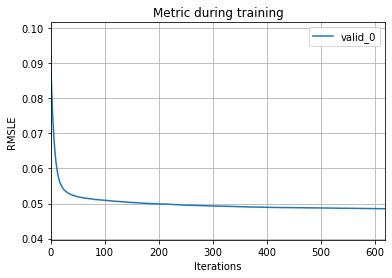

In [88]:
lgb.plot_metric(gbm_model)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

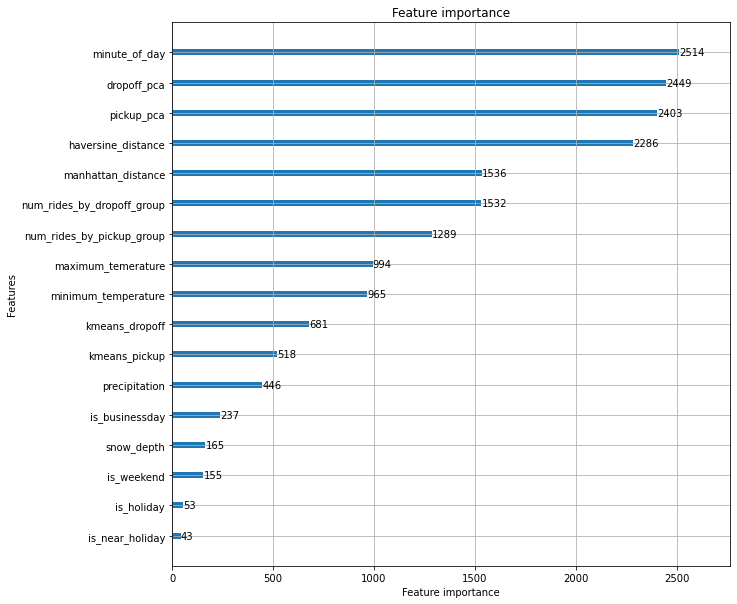

In [89]:
lgb.plot_importance(gbm_model, figsize=(10,10))

In [28]:
from sklearn.metrics import mean_squared_log_error
y_preds = gbm_model.predict(val_x, num_iteration = gbm_model.best_iteration_)
RMSLE = np.sqrt(mean_squared_log_error(val_y, y_preds))

In [29]:
RMSLE

0.04840520209288188

In [30]:
result={'Model':'LightGBM',
        'Number of trees':gbm_model.n_estimators,
        'RMSLE':RMSLE, 
        'Train time (seconds)':gbm_train_time}

result_df = pd.DataFrame(result, index=[0])
result_df

,Model,Number of trees,RMSLE,Train time (seconds)
0,LightGBM,1000,0.048405,24.075394


In [31]:
result_df.to_csv('gbm_results.csv',index=False)

In [32]:
pd.DataFrame(best_gbm.best_params_, index=[0])

,reg_lambda,reg_alpha,n_estimators,max_depth,learning_rate,bagging_freq,bagging_fraction
0,0.6,1.0,1000,6,0.1,2,0.4


In [90]:
pred_gbm = gbm_model.predict(new_test)
pred_gbm = np.exp(pred_gbm)
print('Test shape OK.') if new_test.shape[0] == pred_gbm.shape[0] else print('Oops')
pred_gbm

Test shape OK.


array([ 783.7635644 ,  661.26026319,  264.94336205, ..., 1401.33604572,
       1944.63807212, 1272.05534228])

In [91]:
test_df.reset_index(inplace=True)

In [92]:
test_df['trip_duration'] = pred_gbm

In [93]:
submission_gbm = test_df[['id', 'trip_duration']]

In [94]:
submission_gbm

,id,trip_duration
0,id3004672,783.763564
1,id3505355,661.260263
2,id1217141,264.943362
3,id2150126,1067.558303
4,id1598245,276.779793
...,...,...
625129,id3008929,261.833582
625130,id3700764,1112.377995
625131,id2568735,1401.336046
625132,id1384355,1944.638072


In [95]:
submission_gbm.to_csv('submission-gbm.csv',index=False)

## Try to improve model
***

Remove leat important features

In [126]:
train_df=pd.read_csv("./datasets/train_ds.csv")
test_df=pd.read_csv("./datasets/test_ds.csv")

In [127]:
y = np.log(train_df['trip_duration'].values)

In [128]:
DO_NOT_USE_FOR_TRAINING = ['id', 'pickup_datetime', 'dropoff_datetime','pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'trip_duration', 'date',
       'month', 'weekday', 'hour', 'minute', 'second', 'passenger_count',
       'distance', 'best_travel_time', 'left',
       'right', 'merge', 'on ramp', 'off ramp', 'fork', 'end of road',
       'continue', 'roundabout', 'rotary', 'roundabout turn', 
       'average temperature','departure', 'HDD', 'CDD', 'snow fall', 'is_near_holiday', 'is_holiday']

In [129]:
train_df = train_df.drop([col for col in DO_NOT_USE_FOR_TRAINING if col in train_df], axis=1)
new_test = test_df.drop([col for col in DO_NOT_USE_FOR_TRAINING if col in test_df], axis=1)

In [130]:
train_df

,store_and_fwd_flag,is_weekend,is_businessday,minute_of_day,haversine_distance,manhattan_distance,pickup_pca,dropoff_pca,maximum temerature,minimum temperature,precipitation,snow depth,kmeans_pickup,kmeans_dropoff,num_rides_by_pickup_group,num_rides_by_dropoff_group
0,0,0,1,1044,1.498523,0.019859,0.008441,-0.009922,51,40,0.29,0.0,1,0,758,745
1,0,0,1,1072,1.136464,0.015518,0.011116,0.017982,51,40,0.29,0.0,1,0,758,745
2,0,0,1,1046,1.421467,0.019760,0.020715,0.004297,51,40,0.29,0.0,1,0,758,745
3,0,0,1,1075,1.660334,0.022827,0.011061,0.020505,51,40,0.29,0.0,1,0,758,745
4,0,0,1,1036,0.242562,0.003330,0.004292,0.005383,51,40,0.29,0.0,1,0,758,745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1438172,0,0,1,178,5.423523,0.070576,-0.043979,-0.107336,57,46,0.00,0.0,0,1,37,37
1438173,0,0,1,171,5.611975,0.081604,-0.033109,-0.072628,80,56,0.00,0.0,0,1,37,37
1438174,0,0,1,147,9.762562,0.134480,-0.023344,-0.090154,80,56,0.00,0.0,0,1,37,37
1438175,0,0,1,85,8.305768,0.095383,-0.195359,-0.215771,73,54,0.00,0.0,2,3,11,2


For comparing the results for raw and optimized data, we'll split and use both

In [131]:
train_x, val_x, train_y, val_y = train_test_split(train_df, y, test_size=0.2)

Try model with less trees - avoid overfitting

In [160]:
new_params = {
    "n_estimators" : 500,
    "max_depth" : 6,
    "bagging_fraction" : 0.4,
    "bagging_freq" : 4,
    "reg_alpha" : 0.2,
    "reg_lambda" : 0.8,
    "learning_rate" : 0.1
}

In [161]:
new_gbm = lgb.LGBMRegressor(**new_params)

In [162]:
start = perf_counter()
new_gbm.fit(train_x, train_y,
             eval_set = [(val_x, val_y)],
            eval_metric = rmsle,
            early_stopping_rounds = 10)
end = perf_counter()
new_gbm_train_time = end-start #in seconds

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[1]	valid_0's l2: 0.460404	valid_0's RMSLE: 0.0928152
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.405607	valid_0's RMSLE: 0.087319
[3]	valid_0's l2: 0.360738	valid_0's RMSLE: 0.0825341
[4]	valid_0's l2: 0.324056	valid_0's RMSLE: 0.0783966
[5]	valid_0's l2: 0.294085	valid_0's RMSLE: 0.074827
[6]	valid_0's l2: 0.269432	valid_0's RMSLE: 0.0717595
[7]	valid_0's l2: 0.24936	valid_0's RMSLE: 0.0691457
[8]	valid_0's l2: 0.232209	valid_0's RMSLE: 0.0668293
[9]	valid_0's l2: 0.218524	valid_0's RMSLE: 0.0649104
[10]	valid_0's l2: 0.20685	valid_0's RMSLE: 0.0632248
[11]	valid_0's l2: 0.197394	valid_0's RMSLE: 0.

<ipython-input-163-e5829f4eeec7>:1: UserWarning: More than one metric available, picking one to plot.
  lgb.plot_metric(gbm_model)


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='RMSLE'>

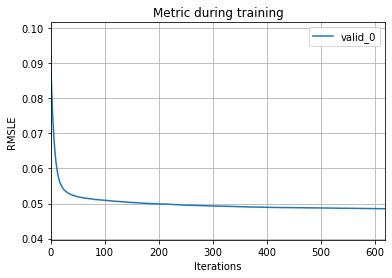

In [163]:
lgb.plot_metric(gbm_model)

In [164]:
pred_gbm = new_gbm.predict(new_test)
pred_gbm = np.exp(pred_gbm)
print('Test shape OK.') if new_test.shape[0] == pred_gbm.shape[0] else print('Oops')
pred_gbm

Test shape OK.


array([ 781.82005766,  644.6579242 ,  245.73004597, ..., 1263.08518616,
       1887.56192657, 1181.01548357])

In [165]:
test_df['trip_duration'] = pred_gbm

In [166]:
submission_gbm = test_df[['id', 'trip_duration']]

In [167]:
submission_gbm

,id,trip_duration
0,id3004672,781.820058
1,id3505355,644.657924
2,id1217141,245.730046
3,id2150126,1126.591509
4,id1598245,258.584687
...,...,...
625129,id3008929,236.564969
625130,id3700764,1057.177268
625131,id2568735,1263.085186
625132,id1384355,1887.561927


In [168]:
submission_gbm.to_csv('new_submission-gbm.csv',index=False)